In this notebook, we'll go over the tools HuggingFace has available for computer vision and multi-modal models that involve vision.

###**Set-up environment**
We'll first install the required libraries: 🤗 Transformers and 🤗 Datasets.

In [ ]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.2 MB/s eta 0:00:00


We'll also install timm as we'll showcase DETR (a Transformer-based object detection model).

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00


4 Main libraries in Hugging Face are:

- transformers
    - Preprocessors
        - For text, tokenizers
        - For image i.e visiom - ImageProcessor
        - For both audio and vision - FeatureExtractor
        - For multimodals - Processor
    - Trainer
    - Models
    - pipeline
    - Tokenizer

- datasets
- tokenizers
- accelerator



###**History of Transformers, its architecture and how they work**

Before talking about hugging face transformer library, lets know about transformers.

The `Transformer architecture` was introduced in June 2017. The focus of the original research was on `translation `. This was followed by the introduction of several influential models, including:
- June 2018: `GPT`, the `first pretrained Transformer model`, used for fine-tuning on various `NLP tasks` and obtained state-of-the-art results
- October 2018: `BERT`, another `large pretrained model`, this one designed to produce better `summaries of sentences`.
- February 2019: `GPT-2`, an improved (and bigger) version of GPT that was not immediately publicly released due to ethical concerns
- October 2019: `DistilBERT`, a `distilled version of BERT` that is 60% faster, 40% lighter in memory, and still retains 97% of BERT’s performance
- October 2019: `BART and T5`, two large pretrained models using the `same architecture as the original Transformer model` (the first to do so)
- May 2020, `GPT-3`, an even bigger version of GPT-2 that is able to perform well on a variety of tasks without the need for fine-tuning (called `zero-shot learning`)

This list is far from comprehensive, and is just meant to highlight a few of the different kinds of Transformer models. Broadly, they can be grouped into `three categories`:

- `GPT-like` (also called `auto-regressive Transformer decoder models`)
- `BERT-like` (also called `auto-encoding Transformer models`)
- `BART/T5-like` (also called `sequence-to-sequence Transformer models`)

We will dive into these families in more depth later on.

**Transformers are language models**

All the Transformer models mentioned above (GPT, BERT, BART, T5, etc.) have been `trained as language models`. This means they have been `trained on large amounts of raw text in a self-supervised fashion`.

**Self-supervised learning** is a type of training in which the objective is automatically computed from the inputs of the model. That means that humans are not needed to label the data!

This type of `model develops a statistical understanding of the language it has been trained on`, but it’s `not very useful for specific practical tasks`. Because of this, the general `pretrained model` then goes through a process called `transfer learning` for task specific training. During this process, the `model is fine-tuned in a supervised way` — that is, `using human-annotated labels — on a given task`.

An example of a task is `predicting the next word in a sentence having read the n previous words`. This is called `causal language modeling` because the output depends on the past and present inputs, but not the future ones.

Another example is `masked language modeling`, in which the `model predicts a masked word in the sentence`.

**Transformers are big models**

Apart from a few outliers (like DistilBERT), the general strategy to achieve better performance is by increasing the models’ sizes as well as the amount of data they are pretrained on.

Unfortunately, training a model, especially a large one, requires a large amount of data. This becomes very costly in terms of time and compute resources. It even translates to environmental impact.

And this is showing a project for a (very big) model led by a team consciously trying to reduce the environmental impact of pretraining. The footprint of running lots of trials to get the best hyperparameters would be even higher.

Imagine if each time a research team, a student organization, or a company wanted to train a model, it did so from scratch. This would lead to huge, unnecessary global costs!

This is why sharing language models is paramount: sharing the trained weights and building on top of already trained weights reduces the overall compute cost and carbon footprint of the community.

By the way, you can `evaluate the carbon footprint of your models’ training` through several tools. For example `ML CO2 Impact` https://mlco2.github.io/impact/ or `Code Carbon` https://codecarbon.io/ which is integrated in 🤗 Transformers. To learn more about this, you can read this blog post https://huggingface.co/blog/carbon-emissions-on-the-hub which will show you how to generate an `emissions.csv` file with an estimate of the footprint of your training, as well as the documentation of 🤗 Transformers addressing this topic.https://huggingface.co/docs/hub/model-cards-co2

#####**General architecture:**

In this section, we’ll go over the general architecture of the Transformer model. Don’t worry if you don’t understand some of the concepts; there are detailed sections later covering each of the components.

**Introduction**

The model is primarily composed of two blocks:

- **`Encoder`** (left): The encoder receives an input and builds a representation of it (its features). This means that the model is optimized to acquire understanding from the input.
- **`Decoder`** (right): The decoder uses the encoder’s representation (features) along with other inputs to generate a target sequence. This means that the model is optimized for generating outputs.

**Each of these parts can be used independently, depending on the task:**

- **`Encoder-only models`**: Good for tasks that require understanding of the input, such as `sentence classification` and `named entity recognition`.
- **`Decoder-only models`**: Good for generative tasks such as `text generation`.
- **`Encoder-decoder models` or `sequence-to-sequence models`**: Good for `generative tasks` that require an input, such as `translation` or `summarization`.

We will dive into those architectures independently in later sections.

**Attention layers**

A key feature of Transformer models is that they are built with special layers called `attention layers`. In fact, the title of the paper introducing the Transformer architecture was `“Attention Is All You Need”!` We will explore the details of attention layers later in the course; for now, all you need to know is that this layer will tell the model to pay specific attention to certain words in the sentence you passed it (and more or less ignore the others) when dealing with the representation of each word.

To put this into context, consider the `task of translating text from English to French`.

Given the input “You like this course”, a translation model will need to also attend to the adjacent word “You” to get the proper translation for the word “like”, because in French the verb “like” is conjugated differently depending on the subject. The rest of the sentence, however, is not useful for the translation of that word. In the same vein, when translating “this” the model will also need to pay attention to the word “course”, because “this” translates differently depending on whether the associated noun is masculine or feminine. Again, the other words in the sentence will not matter for the translation of “this”. With more complex sentences (and more complex grammar rules), the model would need to pay special attention to words that might appear farther away in the sentence to properly translate each word.

The same concept applies to any task associated with natural language: `a word by itself has a meaning, but that meaning is deeply affected by the context, which can be any other word (or words) before or after the word being studied`.

Now that you have an idea of what attention layers are all about, let’s take a closer look at the Transformer architecture.

**The original architecture**

The Transformer architecture was originally designed for translation.

**During training**, the `encoder` receives inputs (sentences) in a certain language, while the `decoder` receives the same sentences in the desired target language.

In the `encoder`, **the attention layers can use all the words in a sentence** (since, as we just saw, the translation of a given word can be dependent on what is after as well as before it in the sentence). The `decoder`, however, **works sequentially and can only pay attention to the words in the sentence that it has already translated** (so, only the words before the word currently being generated).

For example, when we have predicted the first three words of the translated target, we give them to the decoder which then uses all the inputs of the encoder to try to predict the fourth word.

To speed things up during training (when the model has access to target sentences), the decoder is fed the whole target, but it is not allowed to use future words (if it had access to the word at position 2 when trying to predict the word at position 2, the problem would not be very hard!). For instance, when trying to predict the fourth word, the attention layer will only have access to the words in positions 1 to 3.

The original Transformer architecture looked like the encoder on the left and the decoder on the right

The first attention layer in a decoder block pays attention to all (past) inputs to the decoder, but the second attention layer uses the output of the encoder. It can thus access the whole input sentence to best predict the current word. This is very useful as different languages can have grammatical rules that put the words in different orders, or some context provided later in the sentence may be helpful to determine the best translation of a given word.

The `attention mask` can also be used in the encoder/decoder to prevent the model from paying attention to some special words — for instance, the special padding word used to make all the inputs the same length when batching together sentences.

**Architectures vs. checkpoints**

As we dive into Transformer models in this course, you’ll see mentions of `architectures` and `checkpoints` as well as `models`. These terms all have slightly different meanings:

- `Architecture`: This is the skeleton of the model — the definition of each layer and each operation that happens within the model.
- `Checkpoints`: These are the weights that will be loaded in a given architecture.
- `Model`: This is an umbrella term that isn’t as precise as “architecture” or “checkpoint”: it can mean both. This course will specify architecture or checkpoint when it matters to reduce ambiguity.

For example, `BERT` is an `architecture` while `bert-base-cased`, a set of weights trained by the Google team for the first release of BERT, is a `checkpoint`. However, one can say “the BERT model” and “the bert-base-cased model.”

**Encoder models**

`Encoder models` use only the encoder of a Transformer model. At each stage, the attention layers can access all the words in the initial sentence. These models are often characterized as having `“bi-directional” attention`, and are often called `auto-encoding models`.

The `pretraining of these models usually revolves around somehow corrupting a given sentence (for instance, by masking random words in it) and tasking the model with finding or reconstructing the initial sentence`.

Encoder models are best `suited for tasks` requiring an `understanding of the full sentence`, such as `sentence classification, named entity recognition (and more generally word classification), and extractive question answering`.

Representatives of this family of models include:
- ALBERT
- BERT
- DistilBERT
- ELECTRA
- RoBERTa

**Decoder Models**

`Decoder models` use only the decoder of a Transformer model. At each stage, for a given word the attention layers can only access the words positioned before it in the sentence. These models are often called `auto-regressive models`.

The `pretraining of decoder models` usually revolves around `predicting the next word in the sentence`.

These models are best suited for tasks involving `text generation`.

Representatives of this family of models include:
- CTRL
- GPT
- GPT-2
- Transformer XL

**Encoder-decoder models/  sequence-to-sequence models**

`Encoder-decoder models` (also called `sequence-to-sequence models`) use both parts of the Transformer architecture.

At each stage, the attention layers of the encoder can access all the words in the initial sentence, whereas the attention layers of the decoder can only access the words positioned before a given word in the input.

The `pretraining of these models can be done using the objectives of encoder or decoder models, but usually involves something a bit more complex. For instance, T5 is pretrained by replacing random spans of text (that can contain several words) with a single mask special word, and the objective is then to predict the text that this mask word replaces`.

Sequence-to-sequence models are `best suited for tasks revolving around generating new sentences depending on a given input, such as summarization, translation, or generative question answering`.

Representatives of this family of models include:
- BART
- mBART
- Marian
- T5


We discussed how Transformer models work at a high level. A key aspect is that you can use the full architecture or only the encoder or decoder, depending on what kind of task you aim to solve. The following table summarizes this:

**Model- 	Examples -	Tasks**
- Encoder -	ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa	- Sentence classification, named entity recognition, extractive question answering
- Decoder -	CTRL, GPT, GPT-2, Transformer XL - Text generation
- Encoder-decoder -	BART, T5, Marian, mBART	- Summarization, translation, generative question answering


###**Transformers, what can they do?**

In this section, we will look at what Transformer models can do and use our first tool from the 🤗 Transformers library: the `pipeline()` function.

Transformer models are used to solve all kinds of tasks. Many companies and organizations using Hugging Face and Transformer models,  also contribute back to the community by sharing their models.

The 🤗 Transformers library https://github.com/huggingface/transformers provides the functionality to create and use those shared models. The Model Hub https://huggingface.co/models contains thousands of pretrained models that anyone can download and use. You can also upload your own models to the Hub!

Before diving into how Transformer models work under the hood, let’s look at a few examples of how they can be used to solve some interesting NLP problems.



####**Working with `pipeline()` from transformer library**

The most basic object  or the high level apo in the 🤗 Transformers library is the `pipeline()` function. It connects a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any input like text/image based on the mdoel we choose and get an answer/prediction without any further pre and post processing. Pipeline will does it all for us based on the model/task we chose.

If only given the task name but not the model name, by default, this pipeline selects a particular pretrained model that has been fine-tuned for given task eg:(sentiment- analysis).

In [ ]:
from transformers import pipeline

classifier = pipeline(task="sentiment-analysis")
classifier

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
classifier("I've been waiting for a HuggingFace course my whole life.")

[{'label': 'POSITIVE', 'score': 0.9598048329353333}]

We can even pass several sentences that represents batch to a pipeline in the form of list!

In [ ]:
classifier(
    ["I've been waiting for a HuggingFace course my whole life.", "I hate this so much!"]
)

[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

The model is downloaded and cached when you create the classifier object. If you rerun the command, the cached model will be used instead and there is no need to download the model again.

Here, we are using `sentiment-analysis` task for text sentiment analysis.

There are three main steps involved when you pass some text to a pipeline:

- The text is preprocessed into a format the model can understand and trained with.
- The preprocessed inputs are passed to the best available default model set for sentiment analysis in the hub.
- The predictions of the model are post-processed, so you can make sense of them.

Some of the currently available pipelines are https://huggingface.co/transformers/main_classes/pipelines.html:

- feature-extraction
- ner(named entity recognition)
- question-answering
- sentiment-analysis
- summarization
- text-generation
- translation
- zero-shot-classification
```
['audio-classification', 'automatic-speech-recognition', 'conversational', 'depth-estimation', 'document-question-answering', 'feature-extraction', 'fill-mask', 'image-classification', 'image-segmentation', 'image-to-image', 'image-to-text', 'mask-generation', 'ner', 'object-detection', 'question-answering', 'sentiment-analysis', 'summarization', 'table-question-answering', 'text-classification', 'text-generation', 'text-to-audio', 'text-to-speech', 'text2text-generation', 'token-classification', 'translation', 'video-classification', 'visual-question-answering', 'vqa', 'zero-shot-audio-classification', 'zero-shot-classification', 'zero-shot-image-classification', 'zero-shot-object-detection', 'translation_XX_to_YY']
```

Note: the above pipelines mentioned are related to  NLP. Pipelines have all other realted tasks like vision, audio, multimodal, reinforcement learning ..

Lets have a look at few of these

#####**Zero-shot classification**
We’ll start by tackling a more challenging task where we need to classify texts that haven’t been labelled. This is a common scenario in real-world projects because annotating text is usually time-consuming and requires domain expertise. For this use case, the zero-shot-classification pipeline is very powerful: it allows you to specify which labels to use for the classification, so you don’t have to rely on the labels of the pretrained model. You’ve already seen how the model can classify a sentence as positive or negative using those two labels — but it can also classify the text using any other set of labels you like.

In [ ]:
from transformers import pipeline

classifier = pipeline(task="zero-shot-classification")

classifier(sequences="This is a course about the Transformers library",
           candidate_labels=["education", "politics", "business"])

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

{'sequence': 'This is a course about the Transformers library',
 'labels': ['education', 'business', 'politics'],
 'scores': [0.8445989489555359, 0.11197412759065628, 0.04342695698142052]}

This pipeline is called `zero-shot` because you don’t need to fine-tune the model on your data to use it. It can directly return probability scores for any list of labels you want!

#####**Text generation**
Now let’s see how to use a pipeline to generate some text.

The main idea here is that you provide a prompt and the model will auto-complete it by generating the remaining text. This is similar to the predictive text feature that is found on many phones. Text generation involves randomness, so it’s normal if you don’t get the same results as shown below.

In [ ]:
from transformers import pipeline

generator = pipeline(task="text-generation")
generator(text_inputs="In this course, we will teach you how to")

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'In this course, we will teach you how to set up the Python library in Python 3.7. If your first language requires one, you would be all set.\n\nTo learn how to use the Python and C libraries in Python 3.'}]

You can control how many different sequences are generated with the argument `num_return_sequences` and the total length of the output text with the argument `max_length`.

In [ ]:
from transformers import pipeline

generator = pipeline(task="text-generation")
generator(text_inputs="In this course, we will teach you how to",
          num_return_sequences=2,
          max_length=500)

No model was supplied, defaulted to gpt2 and revision 6c0e608 (https://huggingface.co/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "In this course, we will teach you how to work with and use a new language and application. Through a combination of lessons, practice tests, exercises, and hand-holding techniques, I hope you will become a good listener, help you overcome your learning challenges, and gain some amazing insights into your life.\n\nThe purpose of the class is to ensure that all students become fluent learners as students practice their language development, get their hands dirty with the concepts and concepts they've been struggling with, learn how to use our tools to give them a much more interesting and interesting experience, and learn the tools that they need through those lessons.\n\nThis course is no longer open to students who aren't already students. It's very much about how you approach your life, and learning through our programs.\n\nPlease call us on +1 (855) 745-6090. We are happy to talk to you in person or online.\n\nThe class is open to any student from anywhere on Ear

#####**Using any model from the Hub in a pipeline**
The previous examples used the `default model` for the task at hand, but you can also choose a particular model from the Hub to use in a pipeline for a specific task — say, text generation.

Go to the Model Hub https://huggingface.co/models and click on the corresponding tag on the left to display only the supported models for that task. You should get to a page like this one. https://huggingface.co/models?pipeline_tag=text-generation

Let’s try the `distilgpt2 `model for text generation! Here’s how to load it in the same pipeline as before:  

In [ ]:
from transformers import pipeline

generator = pipeline(task="text-generation", model="distilgpt2")

generator(
    text_inputs="In this course, we will teach you how to",
    max_length=30,
    num_return_sequences=2
)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'In this course, we will teach you how to practice yoga without compromising on knowledge and practice. This course will be taught to every student. After spending'},
 {'generated_text': "In this course, we will teach you how to read. In case you haven't yet used these tutorials, you can check them out here. We"}]

You can refine your search for a model by clicking on the language tags, and pick a model that will generate text in another language. The Model Hub even contains checkpoints for multilingual models that support several languages.

Once you select a model by clicking on it, you’ll see that there is a widget enabling you to try it directly online. This way you can quickly test the model’s capabilities before downloading it.

#####**Using pipeline on large models with 🤗 accelerate :**

You can easily run pipeline on large models using 🤗 accelerate that enables paralleization and auto device placement! First make sure you have installed accelerate with `!pip install -q accelerate -U`.

First load your model using `device_map="auto"`!

We will use `facebook/opt-1.3b` for text geneneration for our example.

In [ ]:
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import pipeline

pipe = pipeline(model="facebook/opt-1.3b", device_map="auto", torch_dtype=torch.bfloat16)
out = pipe("This is a cool example!", do_sample=True, top_p=0.5)
out

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

[{'generated_text': 'This is a cool example!  I wonder if the other two are the same way.  I'}]

#####**Pipeline with quantization**
Quantization techniques reduces memory and computational costs by representing weights and activations with lower-precision data types like 8-bit integers (int8). This enables loading larger models you normally wouldn’t be able to fit into memory, and speeding up inference. Transformers supports the AWQ and GPTQ quantization algorithms and it supports 8-bit and 4-bit quantization with bitsandbytes library.

https://huggingface.co/docs/transformers/quantization

You can also pass 8-bit loaded models if you install `bitsandbytes` and add the argument `load_in_8bit=True` to the pipeline

In [ ]:
pip install -i https://test.pypi.org/simple/ bitsandbytes accelerate

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
import torch
from transformers import pipeline

pipe = pipeline(model="facebook/opt-1.3b", device_map="auto", model_kwargs={"load_in_8bit": True})
out = pipe("This is a cool example!", do_sample=True, top_p=0.5)
out

#####**Multimodal pipeline**
The pipeline() supports more than one modality. For example, a visual question answering (VQA) task combines text and image. Feel free to use any image link you like and a question you want to ask about the image. The image can be a URL or a local path to the image.

For example, if you use this invoice image:
https://huggingface.co/spaces/impira/docquery/resolve/2359223c1837a7587402bda0f2643382a6eefeab/invoice.png

Note: To run the example above you need to have `pytesseract` installed in addition to 🤗 Transformers:

```
sudo apt install -y tesseract-ocr
pip install pytesseract
```

In [ ]:
!sudo apt install -y tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,437 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
from transformers import pipeline

vqa = pipeline(model="impira/layoutlm-document-qa")
out = vqa(image="https://huggingface.co/spaces/impira/docquery/resolve/2359223c1837a7587402bda0f2643382a6eefeab/invoice.png",
    question="What is the invoice number?")
out

[{'score': 0.42514568567276, 'answer': 'us-001', 'start': 16, 'end': 16}]

#####**Pipeline parameters**

`pipeline()` supports many parameters; some are task specific, and some are general to all pipelines.

In general, you can specify parameters anywhere you want:

```
transcriber = pipeline(model="openai/whisper-large-v2", my_parameter=1)

out = transcriber(...)  # This will use `my_parameter=1`.
out = transcriber(..., my_parameter=2)  # This will override and use `my_parameter=2`.
out = transcriber(...)  # This will go back to using `my_parameter=1`.

```

######**Device parameter**
If you use `device=n`, the pipeline automatically puts the model on the specified device. This will work regardless of whether you are using PyTorch or Tensorflow.

In [ ]:
from transformers import pipeline
transcriber = pipeline(model="openai/whisper-large-v2", device=0)

config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/4.26k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

RuntimeError: ignored

If the model is too large for a single GPU and you are using `PyTorch`, you can set `device_map="auto"` as the pipeline argument to automatically determine how to load and store the model weights. Using the `device_map` argument requires the 🤗 `Accelerate package.`

The following code automatically loads and stores model weights across devices.

Note that if `device_map="auto"` is passed, there is no need to add the argument `device=device` when instantiating your pipeline as you may encounter some unexpected behavior!

In [ ]:
transcriber = pipeline(model="openai/whisper-large-v2", device_map="auto")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


######**Batch size parameter**
By default, pipelines will not batch inference for reasons explained in detail here https://huggingface.co/docs/transformers/main_classes/pipelines#pipeline-batching. The reason is that batching is not necessarily faster, and can actually be quite slower in some cases.

But if it works in your use case, you can use:

In [ ]:
transcriber = pipeline(model="openai/whisper-large-v2", device_map="auto", batch_size=2)
audio_filenames = [f"https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/{i}.flac" for i in range(1, 5)]
texts = transcriber(audio_filenames)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
texts

[{'text': ' He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered, flour-fattened sauce.'},
 {'text': ' Stuff it into you, his belly counselled him.'},
 {'text': ' After early nightfall the yellow lamps would light up here and there the squalid quarter of the brothels.'},
 {'text': ' And in the medium submerged branches, some birds of the chimerical and legendary plumage flutter.'}]

This runs the pipeline on the 4 provided audio files, but it will pass them in batches of 2 to the model (which is on a GPU, where batching is more likely to help) without requiring any further code from you. The output should always match what you would have received without batching. It is only meant as a way to help you get more speed out of a pipeline.

Pipelines can also alleviate some of the complexities of batching because, for some pipelines, a single item (like a long audio file) needs to be chunked into multiple parts to be processed by a model. The pipeline performs this chunk batching for you.

######**tok_k parameter**

In [ ]:
from transformers import pipeline

unmasker = pipeline(task="fill-mask")
unmasker("This course will teach you all about <mask> models.", top_k=2)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[{'score': 0.19619806110858917,
  'token': 30412,
  'token_str': ' mathematical',
  'sequence': 'This course will teach you all about mathematical models.'},
 {'score': 0.04052723944187164,
  'token': 38163,
  'token_str': ' computational',
  'sequence': 'This course will teach you all about computational models.'}]

#####**Task specific parameters**
All tasks provide task specific parameters which allow for additional flexibility and options to help you get your job done. For instance, the
`transformers.AutomaticSpeechRecognitionPipeline.call()` method has a `return_timestamps` parameter which sounds promising for subtitling videos:



In [ ]:
transcriber = pipeline(model="openai/whisper-large-v2", return_timestamps=True)
transcriber("https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/mlk.flac")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'text': ' I have a dream that one day this nation will rise up and live out the true meaning of its creed.',
 'chunks': [{'timestamp': (0.0, 11.88),
   'text': ' I have a dream that one day this nation will rise up and live out the true meaning of its'},
  {'timestamp': (11.88, 12.38), 'text': ' creed.'}]}

As you can see, the model inferred the text and also outputted when the various sentences were pronounced.

There are many parameters available for each task, so check out each task’s API reference to see what you can tinker with! For instance, the `AutomaticSpeechRecognitionPipeline` has a `chunk_length_s` parameter which is helpful for working on really long audio files (for example, subtitling entire movies or hour-long videos) that a model typically cannot handle on its own:




In [ ]:
transcriber = pipeline(model="openai/whisper-large-v2", chunk_length_s=30, return_timestamps=True)
transcriber("https://huggingface.co/datasets/sanchit-gandhi/librispeech_long/resolve/main/audio.wav")

#####**Using pipelines for inference on a large dataset using iterator and KeyDataset**
The pipeline can also run inference on a large dataset. The easiest way we recommend doing this is by using an iterator






In [ ]:
#dummy data iterator
from transformers import pipeline

def data():
    for i in range(1000):
        yield f"My example {i}"

#text generation model
pipe = pipeline(model="gpt2", device_map="auto")
output = pipe(data())


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
output

In [ ]:
generated_characters = 0
for out in output:
    generated_characters += len(out[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

The `iterator data()` yields each result, and the pipeline automatically recognizes the input is iterable and will start fetching the data while it continues to process it on the GPU (this uses DataLoader under the hood).

This is important because you don’t have to allocate memory for the whole dataset and you can feed the GPU as fast as possible.

Since batching could speed things up, it may be useful to try `tuning the batch_size  parameter` here.

The simplest way to iterate over a dataset is to just load one from 🤗 Datasets

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
# KeyDataset is a util that will just output the item we're interested in. here we are interested in audio field from the dataset
from transformers.pipelines.pt_utils import KeyDataset
import datasets
from datasets import load_dataset

pipe = pipeline(model="hf-internal-testing/tiny-random-wav2vec2", device_map="auto")
dataset = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation[:10]")

for out in pipe(KeyDataset(dataset, "audio")):
    print(out)

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/829k [00:00<?, ?B/s]

ValueError: ignored

#####**The Inference API**
All the models can be tested directly through your browser using the Inference API, which is available on the Hugging Face website https://huggingface.co/. You can play with the model directly on this page by inputting custom text and watching the model process the input data.

The Inference API that powers the widget is also available as a paid product, which comes in handy if you need it for your workflows. See the pricing page https://huggingface.co/pricing for more details.



#####**Mask filling**
The next pipeline you’ll try is fill-mask. The idea of this task is to fill in the blanks in a given text:

In [ ]:
from transformers import pipeline

unmasker = pipeline(task="fill-mask")
unmasker("This course will teach you all about <mask> models.", top_k=2)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

[{'score': 0.19619806110858917,
  'token': 30412,
  'token_str': ' mathematical',
  'sequence': 'This course will teach you all about mathematical models.'},
 {'score': 0.04052723944187164,
  'token': 38163,
  'token_str': ' computational',
  'sequence': 'This course will teach you all about computational models.'}]

The `top_k` argument controls how many possibilities you want to be displayed. Note that here the model fills in the special `<mask>` word, which is often referred to as a `mask token`.

Other mask-filling models might have different mask tokens, so it’s always good to verify the proper mask word when exploring other models. One way to check it is by looking at the mask word used in the widget.

#####**Named entity recognition**
Named entity recognition (NER) is a task where the model has to find which parts of the input text correspond to entities such as persons, locations, or organizations. Let’s look at an example:

In [ ]:
from transformers import pipeline

ner = pipeline("ner", grouped_entities=True)
ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


[{'entity_group': 'PER',
  'score': 0.9981694,
  'word': 'Sylvain',
  'start': 11,
  'end': 18},
 {'entity_group': 'ORG',
  'score': 0.9796019,
  'word': 'Hugging Face',
  'start': 33,
  'end': 45},
 {'entity_group': 'LOC',
  'score': 0.9932106,
  'word': 'Brooklyn',
  'start': 49,
  'end': 57}]

Here the model correctly identified that Sylvain is a person (PER), Hugging Face an organization (ORG), and Brooklyn a location (LOC).

We pass the option `grouped_entities=True` in the pipeline creation function to tell the pipeline to regroup together the parts of the sentence that correspond to the same entity: here the model correctly grouped `“Hugging” and “Face”` as a single organization, even though the name consists of multiple words.

In fact, as we will see in the `next chapter`, the `preprocessing` even `splits some words into smaller parts`. For instance, `Sylvain` is split into four pieces: `S, ##yl, ##va, and ##in`. In the `post-processing step`, the pipeline successfully `regrouped those pieces`.

#####**Question answering**
The question-answering pipeline answers questions using information from a given context


In [ ]:
from transformers import pipeline

question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn"
)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.6949767470359802, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

#####**Summarization**
Summarization is the task of reducing a text into a shorter text while keeping all (or most) of the important aspects referenced in the text. Here’s an example:

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization")
summarizer(
    """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""
)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

[{'summary_text': ' America has changed dramatically during recent years . The number of engineering graduates in the U.S. has declined in traditional engineering disciplines such as mechanical, civil,    electrical, chemical, and aeronautical engineering . Rapidly developing economies such as China and India continue to encourage and advance the teaching of engineering .'}]

Like with text generation, you can specify a `max_length` or a `min_length` for the result.

#####**Translation**
For translation, you can use a default model if you provide a `language pair` in the `task` name (such as `"translation_en_to_fr"`), but the easiest way is to pick the model you want to use on the `Model Hub`.

Here we’ll try translating from French to English

In [ ]:
from transformers import pipeline

translator = pipeline("translation_en_to_fr")
translator("This course is produced by Hugging Face.")

No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[{'translation_text': 'Ce cours est produit par Hugging Face.'}]

In [ ]:
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.6 MB/s eta 0:00:00


In [ ]:
# from transformers import pipeline

# translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
# translator("Ce cours est produit par Hugging Face.")

Like with text generation and summarization, you can specify a `max_length` or a `min_length` for the result.

#####**Transfer Learning**

`Pretraining` is the act of training a model from scratch: the weights are randomly initialized, and the training starts without any prior knowledge.

The pretraining of a language model is costly in both time and money. This pretraining is usually done on very large amounts of data. Therefore, it requires a very large corpus of data, and training can take up to several weeks.

`Fine-tuning`, on the other hand, is the training done after a model has been pretrained. To perform fine-tuning, you first acquire a pretrained language model, then perform additional training with a dataset specific to your task.

**Wait — why not simply train directly for the final task?**

There are a couple of reasons:
- The pretrained model was already trained on a dataset that has some similarities with the fine-tuning dataset. The fine-tuning process is thus able to take advantage of knowledge acquired by the initial model during pretraining (for instance, with NLP problems, the pretrained model will have some kind of statistical understanding of the language you are using for your task).
- Since the pretrained model was already trained on lots of data, the fine-tuning requires way less data to get decent results.
For the same reason, the amount of time and resources needed to get good results are much lower.


For example, one could leverage a pretrained model trained on the English language and then fine-tune it on an arXiv corpus, resulting in a science/research-based model. The `fine-tuning will only require a limited amount of data`: **the knowledge the pretrained model has acquired is “transferred,”** hence the term `transfer learning`.

The fine-tuning of a language model is cheaper than pretraining in both time and money.
Fine-tuning a model therefore has lower time, data, financial, and environmental costs. It is also quicker and easier to iterate over different fine-tuning schemes, as the training is less constraining than a full pretraining.

This process will also achieve better results than training from scratch (unless you have lots of data), which is why you should always try to leverage a pretrained model — one as close as possible to the task you have at hand — and fine-tune it.

#####**Bias and limitations**

If your intent is to use a pretrained model or a fine-tuned version in production, please be aware that, while these models are powerful tools, they come with limitations. The biggest of these is that, to enable pretraining on large amounts of data, researchers often scrape all the content they can find, taking the best as well as the worst of what is available on the internet.

To give a quick illustration, let’s go back the example of a fill-mask pipeline with the BERT model:

In [ ]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model="bert-base-uncased")
result = unmasker("This man works as a [MASK].")
result

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.07510633766651154,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'this man works as a carpenter.'},
 {'score': 0.04641911759972572,
  'token': 5160,
  'token_str': 'lawyer',
  'sequence': 'this man works as a lawyer.'},
 {'score': 0.03914574533700943,
  'token': 7500,
  'token_str': 'farmer',
  'sequence': 'this man works as a farmer.'},
 {'score': 0.032801393419504166,
  'token': 6883,
  'token_str': 'businessman',
  'sequence': 'this man works as a businessman.'},
 {'score': 0.029292341321706772,
  'token': 3460,
  'token_str': 'doctor',
  'sequence': 'this man works as a doctor.'}]

In [ ]:
print([r["token_str"] for r in result])

['carpenter', 'lawyer', 'farmer', 'businessman', 'doctor']


In [ ]:
result = unmasker("This woman works as a [MASK].")
print([r["token_str"] for r in result])

['nurse', 'maid', 'teacher', 'waitress', 'prostitute']


When asked to fill in the missing word in these two sentences, the model gives only one gender-free answer (waiter/waitress). The others are work occupations usually associated with one specific gender — and yes, prostitute ended up in the top 5 possibilities the model associates with “woman” and “work.” This happens even though BERT is one of the rare Transformer models not built by scraping data from all over the internet, but rather using apparently neutral data (it’s trained on the `English Wikipedia` and `BookCorpus` datasets).

When you use these tools, you therefore need to keep in the back of your mind that the original model you are using could very easily generate sexist, racist, or homophobic content. Fine-tuning the model on your data won’t make this `intrinsic bias` disappear.

In this chapter, you saw how to approach different NLP tasks using the high-level `pipeline()` function from 🤗 Transformers. You also saw how to search for and use models in the Hub, as well as how to use the Inference API to test the models directly in your browser.

We discussed how Transformer models work at a high level, and talked about the importance of transfer learning and fine-tuning.

In the next chapter, you’ll learn what’s inside a `pipeline()` function and how to customize its behavior.

##### **What happens when we use Transformers pipeline()**

**Pipeline = Tokenizer -> Model -> Postprocessing**

Note: Here we are talking about text, hence the preprocessor is tokenizer

Transformer models are usually very large. With millions to tens of billions of parameters, training and deploying these models is a complicated undertaking. Furthermore, with new models being released on a near-daily basis and each having its own implementation, trying them all out is no easy task.

The 🤗 `Transformers library` was created to solve this problem. Its `goal` is to provide a `single API` through which `any Transformer model can be loaded, trained, and saved`.

The library’s main features are:

- Ease of use: Downloading, loading, and using a state-of-the-art models for inference can be done in just two lines of code.
- Flexibility: At their core, all `models` are simple `PyTorch nn.Module` or `TensorFlow tf.keras.Model classes` and can be handled like any other models in their respective machine learning (ML) frameworks.
- Simplicity: Hardly any abstractions are made across the library. The “All in one file” is a core concept: a model’s forward pass is entirely defined in a single file, so that the code itself is understandable and hackable.


This last feature makes 🤗 Transformers quite different from other ML libraries. The models are not built on modules that are shared across files; instead, each model has its own layers. In addition to making the models more approachable and understandable, this allows you to easily experiment on one model without affecting others.

- This chapter will begin with an end-to-end example where we use a model and a tokenizer together to `replicate the pipeline() function` introduced in Chapter 1.
- Next, we’ll look at the `tokenizer API` from transformers called `AutoTokenizer`:
    - It is the other main component of the `pipeline()` function. `Tokenizers` take care of the `first and last processing steps`, handling the conversion from text/image to numerical inputs for the neural network, and the conversion back to text/image when it is needed.
- Then, we’ll discuss the `model API` called `AutoModel`
    - We’ll dive into the `model and configuration classes`, and show you how to `load a model` and how it `processes numerical inputs` to `output predictions`.
- Finally, we’ll show you how to handle sending multiple sentences through a model in a `prepared batch`, then wrap it all up with a closer look at the high-level `tokenizer() function`



Lets see how pipeline for sentiment-analysis work under the hood.

In [ ]:
 from transformers import pipeline

 classifier = pipeline("sentiment-analysis")

 classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598048329353333},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

Under the hood, the sentiment analysis pipeline or any pipeline performs preprocessing like tokenization, feeding the tokenized embeddings to model, post processing the logits to understandable labels.

Lets understand how pipeline get the tokenizer from a pretrained model to apply it to its given input

######**Preprocessing with a tokenizer using `AutoTokenizer API`**
Like other neural networks, Transformer models can’t process raw text directly, so the first step of our pipeline is to convert the text inputs into numbers that the model can make sense of. To do this we use a tokenizer, which will be responsible for:

- Splitting the input into words, subwords, or symbols (like punctuation) that are called tokens
- Mapping each token to an integer
- Adding additional inputs that may be useful to the model like [start] and [end] tokens, pos embeddings

All this `preprocessing needs to be done in exactly the same way as when the model was pretrained`, so we **first need to download that information from the Model Hub**.

To do this, we use the `AutoTokenizer class` and its `from_pretrained()` method. Using the `checkpoint name of our model`, it will automatically fetch the data associated with the model’s tokenizer and cache it (so it’s only downloaded the first time you run the code below).

Since the default checkpoint of the sentiment-analysis pipeline is `distilbert-base-uncased-finetuned-sst-2-english`, we run the following:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
pretrained_tokenizer = AutoTokenizer.from_pretrained(checkpoint)

pretrained_tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased-finetuned-sst-2-english', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model!

`The only thing left to do is to convert the list of input IDs to tensors.`

You can use 🤗 Transformers without having to worry about which ML framework is used as a backend; it might be PyTorch or TensorFlow, or Flax for some models. `However, Transformer models only accept tensors as input`.

To specify the type of tensors we want to get back (PyTorch, TensorFlow, or plain NumPy), we use the `return_tensors` argument:

The main things to remember here are that you can pass one sentence or a list of sentences, as well as specifying the type of tensors you want to get back (if no type is passed, you will get a list of lists as a result).

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = pretrained_tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

inputs

{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  1045,  5223,  2023,  2061,  2172,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]])}

Here `padding=True` lets the tokenizer to make all the sentences to have same length, `truncation=True` makes sure that the input sequence is not greater than the context length the model is trained on.

The output itself is a dictionary containing two keys, `input_ids` and `attention_mask`. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. `attention_mask` represents the padded and unpadded token to let the model know not to focus on padded tokens.

######**Going through the model using `AutoModel API`**

We can download our pretrained model the same way we did with our tokenizer. 🤗 Transformers provides an `AutoModel class` which also has a `from_pretrained()` method:

Note: `AutoModel` discards the pretrained model head. It only loads the model until before the head.The head is more specific to pretraine task and hence not needed for new tasks (head is where model performs task specific tasks like classification or generation or anything else)

As it return the high dimensional vector with head, we would need to add new head to get logits and labels

In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
pretrained_model = AutoModel.from_pretrained(checkpoint)

pretrained_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

This architecture contains only the base Transformer module: given some inputs, it outputs what we’ll call hidden states, also known as features. For each model input, we’ll retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model.

While these hidden states can be useful on their own, they’re usually inputs to another part of the model, known as the head. In Chapter 1, the different tasks could have been performed with the same architecture, but each of these tasks will have a different head associated with it.

**A high-dimensional vector?**
The vector output by the Transformer module is usually large. It generally has three dimensions:
- `Batch size`: The number of sequences processed at a time (2 in our example).
- `Sequence length`: No of tokens in a sequence. The length of the numerical representation of the sequence (16 in our example).
- `Hidden size`: The vector dimension of each model input. Each token will have this dimensional vector

It is said to be “high dimensional” because of the last value. The hidden size can be very large (`768` is common for smaller models, and in larger models this can reach `3072` or more).

We can see this if we feed the inputs we preprocessed to our model:

In [ ]:
outputs = pretrained_model(**inputs)
outputs, outputs.keys()

(BaseModelOutput(last_hidden_state=tensor([[[-0.1798,  0.2333,  0.6321,  ..., -0.3017,  0.5008,  0.1481],
          [ 0.2758,  0.6497,  0.3200,  ..., -0.0760,  0.5136,  0.1329],
          [ 0.9046,  0.0985,  0.2950,  ...,  0.3352, -0.1407, -0.6464],
          ...,
          [ 0.1466,  0.5661,  0.3235,  ..., -0.3376,  0.5100, -0.0561],
          [ 0.7500,  0.0487,  0.1738,  ...,  0.4684,  0.0030, -0.6084],
          [ 0.0519,  0.3729,  0.5223,  ...,  0.3584,  0.6500, -0.3883]],
 
         [[-0.2937,  0.7283, -0.1497,  ..., -0.1187, -1.0227, -0.0422],
          [-0.2206,  0.9384, -0.0951,  ..., -0.3643, -0.6605,  0.2407],
          [-0.1536,  0.8988, -0.0728,  ..., -0.2189, -0.8528,  0.0710],
          ...,
          [-0.3017,  0.9002, -0.0200,  ..., -0.1082, -0.8412, -0.0861],
          [-0.3338,  0.9674, -0.0729,  ..., -0.1952, -0.8181, -0.0634],
          [-0.3454,  0.8824, -0.0426,  ..., -0.0993, -0.8329, -0.1065]]],
        grad_fn=<NativeLayerNormBackward0>), hidden_states=None, at

In [ ]:
print(outputs.last_hidden_state.shape)

torch.Size([2, 16, 768])


Note that the `outputs of 🤗 Transformers models` behave like `namedtuples` or `dictionaries`. You can access the elements by attributes (like we did) or by key (outputs["last_hidden_state"]), or even by index if you know exactly where the thing you are looking for is (outputs[0]).

######**`AutoModel with Model heads` and post-processing**

The model heads take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers.

The output of the Transformer model is sent directly to the model head to be processed.

The model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

There are many different architectures available in 🤗 Transformers to get the model with particular head, with each one designed around tackling a specific task. Here is a non-exhaustive list:

- *Model (retrieve the hidden states)
- *ForCausalLM
- *ForMaskedLM
- *ForMultipleChoice
- *ForQuestionAnswering
- *ForSequenceClassification
- *ForTokenClassification
and others 🤗

For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we `won’t actually use the AutoModel` class, but `AutoModelForSequenceClassification` that has head to perform sequence classification

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
pretrained_model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = pretrained_model(**inputs)

outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits

tensor([[-1.5607,  1.6123],
        [ 4.1692, -3.3464]], grad_fn=<AddmmBackward0>)

Our model predicted [-1.5607, 1.6123] for the first sentence and [ 4.1692, -3.3464] for the second one. Those are not probabilities but logits, the raw, unnormalized scores outputted by the last layer of the model. To be converted to probabilities, they need to go through a SoftMax layer (all 🤗 Transformers models output the logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy)

In [ ]:
import torch
preds = torch.softmax(outputs.logits, dim=1)
preds

tensor([[4.0195e-02, 9.5980e-01],
        [9.9946e-01, 5.4418e-04]], grad_fn=<SoftmaxBackward0>)

Now we can see that the model predicted [0.0402, 0.9598] for the first sentence and [0.9995, 0.0005] for the second one. These are recognizable probability scores.

To get the labels corresponding to each position, we can inspect the `id2label` attribute of the `model config`

In [ ]:
pretrained_model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 30522
}

In [ ]:
pretrained_model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

Now we can conclude that the model predicted the following:

- First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
- Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

We have successfully reproduced the three steps of the pipeline:
- preprocessing with tokenizers
- passing the inputs through the model, and
- postprocessing

Now let’s take some time to dive deeper into each of those steps.

#####**How to instantiate a Transformer model from tranformer class rather than AutoModel**

In this section we’ll take a closer look at creating and using a model. We’ll use the `AutoModel class`, which is handy when you want to instantiate any model from a checkpoint. A checkpoint is the named of the modelcard we get from hub. Based on given checkpoint, the `AutoModel` class will look for the right model class. It loads that model class's config file containing architecture details and the model file containing params/weights.

The `AutoModel class` and all of its relatives are actually simple `wrappers over the wide variety of models` available in the library.

 It’s a clever wrapper as it can automatically gets the `appropriate model architecture for your checkpoint`, and `then instantiates a model with this architecture`.

Like AutoModel and AutoTokenizer, we also have an API class called AutoConfig, that will have a from_pretrained() to get any pretrained model config from a checkpoint. We can pass this config to the AutoModel using config attribute. We can even change these configs of pretrained model.



######**`AutoConfig class`**

In [ ]:
from transformers import AutoConfig

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
pretrained_config = AutoConfig.from_pretrained(checkpoint)

pretrained_config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 30522
}

In [ ]:
pretrained_config.hidden_dim = 2072

pretrained_config  #here DistilBertForSequenceClassification is the model class for our checkpoint distilbert-base-uncased-finetuned-sst-2-english

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased-finetuned-sst-2-english",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 2072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 30522
}

We usually pass this config to the AutoModel when using the same model using from_pretrained so that config matches.

However, if you know the type of `model class` you want to use, you can use the class that defines its architecture directly. Let’s take a look at how this works with a `BERT model`.

######**Creating a Transformer**
The first thing we’ll need to do to initialize a BERT model is load a configuration object

In [ ]:
from transformers import BertConfig, BertModel

# Building the config
bert_config = BertConfig()

bert_config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

While you haven’t seen what all of these attributes do yet, you should recognize some of them: the `hidden_size` attribute defines the size of the hidden_states vector, and `num_hidden_layers` defines the number of layers the Transformer model has.

In [ ]:
# Building the model from the config
bert_model = BertModel(config=bert_config)

bert_model

#Note as we didnt use BertModel.from_pretrained() and lodaded the config, the model will be randomly initialized

(BertModel(
   (embeddings): BertEmbeddings(
     (word_embeddings): Embedding(30522, 768, padding_idx=0)
     (position_embeddings): Embedding(512, 768)
     (token_type_embeddings): Embedding(2, 768)
     (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (encoder): BertEncoder(
     (layer): ModuleList(
       (0-11): 12 x BertLayer(
         (attention): BertAttention(
           (self): BertSelfAttention(
             (query): Linear(in_features=768, out_features=768, bias=True)
             (key): Linear(in_features=768, out_features=768, bias=True)
             (value): Linear(in_features=768, out_features=768, bias=True)
             (dropout): Dropout(p=0.1, inplace=False)
           )
           (output): BertSelfOutput(
             (dense): Linear(in_features=768, out_features=768, bias=True)
             (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
             (dropout): Dropout(p=

######**Different loading methods**

Creating a model from the default configuration initializes it with random values.

Thats what happened in the earlier cell.

```
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

# Model is randomly initialized!
```

The model can be used in this state, but it will output gibberish; it needs to be trained first. We could train the model from scratch on the task at hand, but as you saw in Chapter 1, this would require a long time and a lot of data, and it would have a non-negligible environmental impact. To avoid unnecessary and duplicated effort, it’s imperative to be able to share and reuse models that have already been trained.

Loading a Transformer model that is already trained is simple — we can do this using the `from_pretrained()` method:

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained(pretrained_model_name_or_path="bert-base-cased") #giving the checkpoint

# Model is initialized with pretrained weights

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

As you saw earlier, we could replace `BertModel` with the equivalent `AutoModel` class. We’ll do this from now on as this produces `checkpoint-agnostic code`; if your code works for one checkpoint, it should work seamlessly with another. This applies even if the architecture is different, as long as the checkpoint was trained for a similar task (for example, a sentiment analysis task).

In the code sample above we didn’t use `BertConfig`, and instead loaded a pretrained model via the `bert-base-cased` identifier. This is a model checkpoint that was trained by the authors of BERT themselves; you can find more details about it in its model card.

This model is `now initialized with all the weights of the checkpoint`. It can be used directly for inference on the tasks it was trained on, and it can also be fine-tuned on a new task. By training with pretrained weights rather than from scratch, we can quickly achieve good results.

The weights have been downloaded and cached (so future calls to the from_pretrained() method won’t re-download them) in the cache folder, which defaults to ~/.cache/huggingface/transformers. You can customize your cache folder by setting the `HF_HOME` `environment variable`.

The identifier used to load the model can be the identifier of any model on the Model Hub, as long as it is compatible with the BERT architecture. The entire list of available BERT checkpoints can be found here https://huggingface.co/models?filter=bert.

######**Saving methods**
Saving a model is as easy as loading one — we use the `save_pretrained()` method, which is `analogous to the from_pretrained()` method

`model.save_pretrained("directory_path_on_my_computer")`

This saves two files to your disk:

```
!ls directory_path_on_my_computer

config.json pytorch_model.bin
```

If you take a look at the `config.json` file, you’ll recognize the attributes necessary to build the model architecture. This file also contains some `metadata`, such as `where the checkpoint originated and what 🤗 Transformers version you were using when you last saved the checkpoint`.

The `pytorch_model.bin` or `model.safetensors` file is known as the `state dictionary`; it contains all your model’s weights. The two files go hand in hand; the configuration is necessary to know your model’s architecture, while the model weights are your model’s parameters.

We can load the save model using `newmodelinstance.from_pretrained("directory_path_on_my_ computer")`

In [ ]:
model.save_pretrained("./models")

In [ ]:
!ls models

config.json  model.safetensors


In [ ]:
loaded_model = BertModel.from_pretrained(pretrained_model_name_or_path="./models")
loaded_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

######**Using a Transformer model for inference**
Now that you know how to load and save a model, let’s try using it to make some predictions. Transformer models can only process numbers — numbers that the tokenizer generates. But before we discuss tokenizers, let’s explore what inputs the model accepts.

Tokenizers can take care of casting the inputs to the appropriate framework’s tensors, but to help you understand what’s going on, we’ll take a quick look at what must be done before sending the inputs to the model.

Let’s say we have a couple of sequences:

```
sequences = ["Hello!", "Cool.", "Nice!"]
```

The tokenizer converts these to vocabulary indices which are typically called input IDs.

Each sequence is now a list of numbers! The resulting output is:

```
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]
````
This is a list of encoded sequences: a list of lists. Tensors only accept rectangular shapes (all the tokens should have same length). This “array” is already of rectangular shape, so converting it to a tensor is easy:

```
import torch
model_inputs = torch.tensor(encoded_sequences)
```

**Using the tensors as inputs to the model**

Making use of the tensors with the model is extremely simple — we just call the model with the inputs

```output = model(model_inputs)```

While the model accepts a lot of different arguments, only the input IDs are necessary. We’ll explain what the other arguments do and when they are required later, but first we need to take a closer look at the tokenizers that build the inputs that a Transformer model can understand.

#####**How tokenizers works under the hood to preprocess the model inputs**

Tokenizers are one of the core components of the NLP pipeline. They serve one purpose: to translate text into data that can be processed by the model. Models can only process numbers, so tokenizers need to convert our text inputs to numerical data. In this section, we’ll explore exactly what happens in the tokenization pipeline.

In NLP tasks, the data that is generally processed is raw text. Here’s an example of such text:

"Jim Henson was a puppeteer"

However, models can only process numbers, so we need to find a way to convert the raw text to numbers. That’s what the tokenizers do, and there are a lot of ways to go about this. The goal is to find the most meaningful representation — that is, the one that makes the most sense to the model — and, if possible, the smallest representation.

Let’s take a look at some examples of tokenization algorithms, and try to answer some of the questions you may have about tokenization.
- Word-based tokenizer
- Character based tokenizer
- Sentence based tokenizer
- Sub-word based tokenizer
    - WordPiece Tokenizer
    - Byte Pair Encoding
    - SentencePiece Tokenizer




######**Word-based tokenizer:**

The first type of tokenizer is word-based. It’s generally very easy to set up and use with only a few rules, and it often yields decent results. For example, it splits the text based on spaces or even punctuations, the goal is to split the raw text into words and find a numerical representation for each of them:
```
Let's do tokenization!

(split on spcaes)
Let's  |   do    | tokenization!


(split on spaces and punctuation)
Let | 's  |   do    | tokenization | ! |

```
There are different ways to split the text.

For example, we could use whitespace to tokenize the text into words by applying Python’s `split()` function:

In [ ]:
tokenized_text = "Jim Henson was a puppeteer".split()

tokenized_text

['Jim', 'Henson', 'was', 'a', 'puppeteer']

There are also variations of word tokenizers that have extra rules for punctuation. With this kind of tokenizer, we can end up with some pretty large “vocabularies,” where a vocabulary is defined by the total number of independent tokens that we have in our corpus.

Each word gets assigned an ID, starting from 0 and going up to the size of the vocabulary. The model uses these IDs to identify each word in the dictionary index created using word2vec or Glove.

- If we want to completely cover a language with a word-based tokenizer, we’ll need to have an identifier for each word in the language, which will generate a huge amount of tokens. For example, there are over 500,000 words in the English language, so to build a map from each word to an input ID we’d need to keep track of that many IDs.

- Furthermore, words like “dog” are represented differently from words like “dogs”, and the model will initially have no way of knowing that “dog” and “dogs” are similar: it will identify the two words as unrelated. The same applies to other similar words, like “run” and “running”, which the model will not see as being similar initially.

- Finally, we need a custom token to represent words that are not in our vocabulary. This is known as the “unknown” token, often represented as ”[UNK]” or ””. It’s generally a bad sign if you see that the tokenizer is producing a lot of these tokens, as it wasn’t able to retrieve a sensible representation of a word and you’re losing information along the way. The goal when crafting the vocabulary is to do it in such a way that the tokenizer tokenizes as few words as possible into the unknown token.

One way to reduce the amount of unknown tokens is to go one level deeper, using a `character-based tokenizer`.

######**Character-based tokenizer**

Character-based tokenizers split the text into characters, rather than words. This has two primary benefits:

- The vocabulary is much smaller.
- There are much fewer out-of-vocabulary (unknown) tokens, since every word can be built from characters.

But here too some questions arise concerning spaces and punctuation:

```
Let's do tokenization!

(split on chars)
|L |e | t |' | s | d | o | t |o | k |e |n |i |z |a |t |i |o |n | ! |

```
This approach isn’t perfect either. Since the representation is now based on characters rather than words, one could argue that, intuitively, it’s less meaningful: each character doesn’t mean a lot on its own, whereas that is the case with words. However, this again differs according to the language; in Chinese, for example, each character carries more information than a character in a Latin language.

Another thing to consider is that we’ll end up with a very large amount of tokens in  a sqeuence to be processed by our model: whereas a word would only be a single token with a word-based tokenizer, it can easily turn into 10 or more tokens when converted into characters.

To get the best of both worlds, we can use a third technique that combines the two approaches: `subword tokenization`.


######**Subword tokenization**
Subword tokenization algorithms rely on the principle that frequently used words should not be split into smaller subwords, but rare words should be decomposed into meaningful subwords.

For instance, “annoyingly” might be considered a rare word and could be decomposed into “annoying” and “ly”. These are both likely to appear more frequently as standalone subwords, while at the same time the meaning of “annoyingly” is kept by the composite meaning of “annoying” and “ly”.

Here is an example showing how a subword tokenization algorithm would tokenize the sequence “Let’s do tokenization of different ways!“:

```
Let's</w>  |   do</w>  | token | ization</w> | !</w> |

Let's  |   do  | token | ##ization | ! |

```

These subwords end up providing a lot of semantic meaning: for instance, in the example above “tokenization” was split into “token” and “ization”, two tokens that have a semantic meaning while being space-efficient (only two tokens are needed to represent a long word). This allows us to have relatively good coverage with small vocabularies, and close to no unknown tokens.

This approach is especially useful in agglutinative languages such as Turkish, where you can form (almost) arbitrarily long complex words by stringing together subwords.

Unsurprisingly, there are many more techniques out there. To name a few:

- Byte-level BPE, as used in GPT-2
- WordPiece, as used in BERT
- SentencePiece or Unigram, as used in several multilingual models

You should now have sufficient knowledge of how tokenizers work to get started with the API.

######**Loading and saving the tokenizer**

Loading and saving tokenizers is as simple as it is with models. Actually, it’s based on the same two methods:
- `from_pretrained()`
- `save_pretrained()`

These methods will load or save the algorithm used by the tokenizer (a bit like the architecture of the model) as well as its vocabulary (a bit like the weights of the model).

Loading the BERT tokenizer trained with the same checkpoint as BERT is done the same way as loading the model, except we use the BertTokenizer class

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

tokenizer

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Similar to `AutoModel`, the `AutoTokenizer class` will grab the proper tokenizer class in the library based on the checkpoint name, and can be used directly with any checkpoint.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

We can now use the tokenizer as shown in the previous sections

In [ ]:
tokenizer("Using a Transformer network is simple")

{'input_ids': [101, 7993, 170, 13809, 23763, 2443, 1110, 3014, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

Saving a tokenizer is identical to saving a model:

In [ ]:
tokenizer.save_pretrained("./tokenizers")

('./tokenizers/tokenizer_config.json',
 './tokenizers/special_tokens_map.json',
 './tokenizers/vocab.txt',
 './tokenizers/added_tokens.json',
 './tokenizers/tokenizer.json')

We’ll talk more about `token_type_ids` in Chapter 3, and we’ll explain the `attention_mask` key a little later. First, let’s see how the input_ids are generated. To do this, we’ll need to look at the intermediate methods of the tokenizer.

As we’ve seen, the first step is to split the text into words (or parts of words, punctuation symbols, etc.), usually called tokens. There are multiple rules that can govern that process, which is why we need to instantiate the tokenizer using the name of the model, to make sure we use the same rules that were used when the model was pretrained.

The second step is to convert those tokens into numbers, so we can build a tensor out of them and feed them to the model. To do this, the tokenizer has a vocabulary, which is the part we download when we instantiate it with the from_pretrained() method. Again, we need to use the same vocabulary used when the model was pretrained.

To get a better understanding of the two steps, we’ll explore them separately. Note that we will use some methods that perform parts of the tokenization pipeline separately to show you the intermediate results of those steps, but in practice, you should call the tokenizer directly on your inputs (as shown in the previous sections).

In [ ]:
#under the hood tokenizer encodes the input like below
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokens = tokenizer.tokenize("Using a Transformer network is simple")
encodings = tokenizer.convert_tokens_to_ids(tokens=tokens)

tokens, encodings

(['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple'],
 [7993, 170, 13809, 23763, 2443, 1110, 3014])

Notice This tokenizer is a subword tokenizer: it splits the words until it obtains tokens that can be represented by its vocabulary. That’s the case here with transformer, which is split into two tokens: trans and ##former.

These output encodings, once converted to the appropriate framework tensor, can then be used as inputs to a model as seen earlier in this chapter. torch.tensor(encodings)

In [ ]:
#we can also get the tokens from the encodings using decode
tokenizer.decode(encodings)

'Using a Transformer network is simple'

Note that the decode method not only converts the indices back to tokens, but also groups together the tokens that were part of the same words to produce a readable sentence. This behavior will be extremely useful when we use models that predict new text (either text generated from a prompt, or for sequence-to-sequence problems like translation or summarization).

By now you should understand the atomic operations a tokenizer can handle: tokenization, conversion to IDs, and converting IDs back to a string. However, we’ve just scraped the tip of the iceberg. In the following section, we’ll take our approach to its limits and take a look at how to overcome them.

######**Handling multiple sequences**
In the previous section, we explored the simplest of use cases: doing inference on a single sequence of a small length. However, some questions emerge already:

- How do we handle multiple sequences?
- How do we handle multiple sequences of different lengths?
- Are vocabulary indices the only inputs that allow a model to work well?
- Is there such a thing as too long a sequence?

Let’s see what kinds of problems these questions pose, and how we can solve them using the 🤗 Transformers API.



######**Models expect a batch of inputs**

In the previous exercise you saw how sequences get translated into lists of numbers.

Lets see how the model process the encodings using the manual tokenization



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
encodings = tokenizer.convert_tokens_to_ids(tokens)
input_tensors = torch.tensor(encodings)
outputs = model(input_tensors) # This line will fail.
outputs

IndexError: ignored

Oh no! Why did this fail? “We followed the steps from the pipeline in section 2.

The problem is that we sent a single sequence to the model, whereas 🤗 Transformers models expect multiple sentences by default i.e a batch. Here we tried to do everything the tokenizer did behind the scenes when we applied it to a sequence. But if you look closely, you’ll see that the tokenizer didn’t just convert the list of input IDs into a tensor, it added a dimension on top of it:

In [ ]:
#auto tokenization
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequence = "I've been waiting for a HuggingFace course my whole life."

input_tensors = tokenizer(sequence, return_tensors="pt")
outputs = model(input_tensors["input_ids"])
input_tensors["input_ids"], input_tensors["input_ids"].shape, outputs

(tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
           2607,  2026,  2878,  2166,  1012,   102]]),
 torch.Size([1, 16]),
 SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None))

Let’s try again for the manual tokenization by adding a new batch dimension:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
encodings = tokenizer.convert_tokens_to_ids(tokens)
input_tensors = torch.tensor([encodings]) #added new dimension while converting to tensors
print("Input IDs:", input_tensors)

outputs = model(input_tensors) # This line will fail.
print("Logits:", outputs.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


Batching is the act of sending multiple sentences through the model, all at once. If you only have one sentence, you can just build a batch with a single sequence:

`batched_ids = [ids, ids]`

This is a batch of two identical sequences!

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
encodings = tokenizer.convert_tokens_to_ids(tokens)
input_tensors = torch.tensor([encodings, encodings]) #identical sequences as batch, see whther it returns same logits or differnt logits for identical sequences
print("Input IDs:", input_tensors)

outputs = model(input_tensors) # This line will fail.
print("Logits:", outputs.logits)

Input IDs: tensor([[ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012],
        [ 1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,  2607,
          2026,  2878,  2166,  1012]])
Logits: tensor([[-2.7276,  2.8789],
        [-2.7276,  2.8789]], grad_fn=<AddmmBackward0>)


Batching allows the model to work when you feed it multiple sentences. Using multiple sequences is just as simple as building a batch with a single sequence. There’s a second issue, though. When you’re trying to batch together two (or more) sentences, they might be of different lengths. If you’ve ever worked with tensors before, you know that they need to be of rectangular shape, so you won’t be able to convert the list of input IDs into a tensor directly. To work around this problem, we usually `pad the inputs`.



######**Padding the inputs**
The following list of lists cannot be converted to a tensor:
```
batched_ids = [
    [200, 200, 200],
    [200, 200]
]
```

In order to work around this, we’ll use padding to make our tensors have a rectangular shape.

Padding makes sure all our sentences have the same length by adding a special word called the `padding token` to the sentences with fewer values.

For example, if you have 10 sentences with 10 words and 1 sentence with 20 words, padding will ensure all the sentences have 20 words. In our example, the resulting tensor looks like this:

```
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]
```

The padding token ID can be found in `tokenizer.pad_token_id`. Let’s use it and send our two sentences through the model individually and batched together

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id]]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 1.3374, -1.2163]], grad_fn=<AddmmBackward0>)


There’s something wrong with the logits in our batched predictions: the second row should be the same as the logits for the second sentence, but we’ve got completely different values!

This is because the key feature of Transformer models is attention layers that contextualize each token.

These will take into account the padding tokens since they attend to all of the tokens of a sequence. To get the same result when passing individual sentences of different lengths through the model or when passing a batch with the same sentences and padding applied, we need to tell those attention layers to ignore the padding tokens. This is done by using an `attention mask`.


######**Attention masks**
Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s: 1s indicate the corresponding tokens should be attended to, and 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model).

Let’s complete the previous example with an attention mask:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id]]
attention_mask = [[1, 1, 1],
                  [1, 1, 0]]

batch_outputs = model(torch.tensor(batched_ids),
                      attention_mask=torch.tensor(attention_mask))
print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(batch_outputs.logits)

tensor([[ 1.5694, -1.3895]], grad_fn=<AddmmBackward0>)
tensor([[ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)
tensor([[ 1.5694, -1.3895],
        [ 0.5803, -0.4125]], grad_fn=<AddmmBackward0>)


Now we get the same logits for the second sentence in the batch.

Notice how the last value of the second sequence is a padding ID, which is a 0 value in the attention mask.

######**Longer sequences**
With Transformer models, there is a limit to the lengths of the sequences we can pass the models. Most models handle sequences of up to 512 or 1024 tokens, and will crash when asked to process longer sequences. There are two solutions to this problem:

- Use a model with a longer supported sequence length.
- Truncate your sequences.

Models have different supported sequence lengths, and some specialize in handling very long sequences.

`Longformer` is one example, and another is `LED`. If you’re working on a task that requires very long sequences, we recommend you take a look at those models.

Otherwise, we recommend you truncate your sequences by specifying the `max_sequence_length` parameter:

`sequence = sequence[:max_sequence_length]`

######**Putting it all together**
In the last few sections, we’ve been trying our best to do most of the work by hand. We’ve explored how tokenizers work and looked at tokenization, conversion to input IDs, padding, truncation, and attention masks.

However, as we saw in section 2, the 🤗 Transformers API can handle all of this for us with a high-level function that we’ll dive into here. When you call your tokenizer directly on the sentence, you get back inputs that are ready to pass through your model

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)

model_inputs

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Here, the `model_inputs` variable contains everything that’s necessary for a model to operate well. For DistilBERT, that includes the input IDs as well as the attention mask. Other models that accept additional inputs will also have those output by the tokenizer object.

As we’ll see in some examples below, this method is very powerful. First, it can tokenize a single sequence:



In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)

model_inputs

{'input_ids': [101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

It also handles multiple sequences at a time, with no change in the API:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences)

model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

It can pad according to several objectives

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences, padding=True)

# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)

model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102], [101, 2061, 2031, 1045, 999, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0]]}

It can also truncate sequences:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)

model_inputs

{'input_ids': [[101, 1045, 1005, 2310, 2042, 3403, 2005, 102], [101, 2061, 2031, 1045, 999, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

The tokenizer object can handle the conversion to specific framework tensors, which can then be directly sent to the model. For example, in the following code sample we are prompting the tokenizer to return tensors from the different frameworks — "pt" returns PyTorch tensors, "tf" returns TensorFlow tensors, and "np" returns NumPy arrays using `return_tensors` argument

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# Returns TensorFlow tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="tf")

# Returns NumPy arrays
model_inputs = tokenizer(sequences, padding=True, return_tensors="np")

######**Special tokens**
If we take a look at the input IDs returned by the tokenizer, we will see they are a tiny bit different from what we had earlier:

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

#autotokenization
model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

#manual tokenization
tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

[101, 1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012, 102]
[1045, 1005, 2310, 2042, 3403, 2005, 1037, 17662, 12172, 2607, 2026, 2878, 2166, 1012]


One `token ID` was added at the `beginning`, and one at the `end`.

Let’s decode the two sequences of IDs above to see what this is about:

In [ ]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

[CLS] i've been waiting for a huggingface course my whole life. [SEP]
i've been waiting for a huggingface course my whole life.


The tokenizer added the special word `[CLS]` at the beginning and the special word `[SEP]` at the end. This is because the model was pretrained with those, so to get the same results for inference we need to add them as well.

Note that some models don’t add special words, or add different ones; models may also add these special words only at the beginning, or only at the end. In any case, the tokenizer knows which ones are expected and will deal with this for you.

#####**Wrapping up: From tokenizer to model**
Now that we’ve seen all the individual steps the tokenizer object uses when applied on texts, let’s see one final time how it can handle multiple sequences (padding!), very long sequences (truncation!), and multiple types of tensors with its main API

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5607,  1.6123],
        [-3.6183,  3.9137]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

**Basic usage completed!**

To recap, in this chapter you:

- Learned the basic building blocks of a Transformer model.
- Learned what makes up a tokenization pipeline.
- Saw how to use a Transformer model in practice.
- Learned how to leverage a tokenizer to convert text to tensors that are understandable by the model.
- Set up a tokenizer and a model together to get from text to predictions.
- Learned the limitations of input IDs, and learned about attention masks.
- Played around with versatile and configurable tokenizer methods.

From now on, you should be able to freely navigate the 🤗 Transformers docs: the vocabulary will sound familiar, and you’ve already seen the methods that you’ll use the majority of the time.



###**Fine-tuning a Pretraied Model**

In Chapter 2 we explored how to use tokenizers and pretrained models to make predictions. But what if you want to fine-tune a pretrained model for your own dataset? That’s the topic of this chapter! You will learn:

- How to prepare a large dataset from the Hub
- How to use the high-level Trainer API to fine-tune a model
- How to use a custom training loop
- How to leverage the 🤗 Accelerate library to easily run that custom training loop on any distributed setup



####**Processing the data - `datasets library`**

Continuing with the example from the previous chapter, here is how we would train a sequence classifier on one batch in PyTorch

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.optim import AdamW

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequence = ["I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",]

#Tokenization
batch = tokenizer(sequence, padding=True, truncation=True, return_tensors="pt")
print(batch)

#------------New------------------
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(params=model.parameters(), lr=0.001)
loss = model(**batch).loss
loss.backward()
optimizer.step()

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': tensor([[  101,  1045,  1005,  2310,  2042,  3403,  2005,  1037, 17662, 12172,
          2607,  2026,  2878,  2166,  1012,   102],
        [  101,  2023,  2607,  2003,  6429,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


Of course, just training the model on two sentences is not going to yield very good results. To get better results, you will need to prepare a bigger dataset.

In this section we will use as an example the `MRPC` (Microsoft Research Paraphrase Corpus) dataset, introduced in a paper by William B. Dolan and Chris Brockett.

The dataset consists of `5,801 pairs of sentences`, with a `label` indicating if they are paraphrases or not (i.e., if both sentences mean the same thing).

We’ve selected it for this chapter because it’s a small dataset, so it’s easy to experiment with training on it.

The Hub doesn’t just contain models; it also has multiple datasets in lots of different languages. You can browse the datasets here https://huggingface.co/datasets, and we recommend you try to load and process a new dataset once you have gone through this section (see the general documentation here https://huggingface.co/docs/datasets/loading_datasets.html#from-the-huggingface-hub). But for now, let’s focus on the MRPC dataset! This is one of the `10 datasets` composing the `GLUE benchmark`, which is an academic benchmark that is used to measure the performance of ML models across `10 different text classification` tasks.

The 🤗 `Datasets library` provides a very simple command to download and cache a dataset on the Hub. We can download the MRPC dataset like this:

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset(path="glue", name="mrpc")
raw_datasets

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

As you can see, we get a `DatasetDict` object which contains the `training set`, the `validation set`, and the `test set`. Each of those contains `several columns` (`sentence1, sentence2, label, and idx`) and a `variable number of rows`, which are the number of elements in each set (so, there are `3,668 pairs of sentences in the training set`, `408 in the validation set`, and `1,725 in the test set`).

This command downloads and caches the dataset, by default in `~/.cache/huggingface/datasets`. Recall from Chapter 2 that you can customize your cache folder by setting the `HF_HOME environment variable`.

We can access each pair of sentences in our `raw_datasets` object by indexing, like with a dictionary

In [ ]:
raw_datasets.items()

dict_items([('train', Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})), ('validation', Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 408
})), ('test', Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 1725
}))])

In [ ]:
raw_datasets.keys()

dict_keys(['train', 'validation', 'test'])

In [ ]:
raw_datasets["train"]

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx'],
    num_rows: 3668
})

In [ ]:
#Indexing to access data
raw_datasets["train"][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

We can see the labels are already integers, so we won’t have to do any preprocessing there like converting string labels to integers using label2id.

To know which integer corresponds to which label, we can inspect the `features` of our `raw_train_dataset`. This will tell us the type of each column:

In [ ]:
raw_datasets["train"].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [ ]:
raw_datasets["train"].features["label"]

ClassLabel(names=['not_equivalent', 'equivalent'], id=None)

Behind the scenes, `label` is of type `ClassLabel`, and the mapping of integers to label name is stored in the names folder.

`0 corresponds to not_equivalent, and 1 corresponds to equivalent`.

In [ ]:
raw_datasets["train"].features["label"].names

['not_equivalent', 'equivalent']

In [ ]:
#we also info about the input data which are pairs of sentences here
raw_datasets["train"].features["sentence1"]

Value(dtype='string', id=None)

In [ ]:
raw_datasets["train"].features["sentence2"]

Value(dtype='string', id=None)

In [ ]:
raw_datasets["train"].num_rows #no of samples in the train data set.

3668

In [ ]:
raw_datasets["validation"].num_rows #no of samples in the train data set.

408

In [ ]:
raw_datasets["validation"][13] #accessing the data from the validation dataset

{'sentence1': 'The only announced Republican to replace Davis is Rep. Darrell Issa of Vista , who has spent $ 1.71 million of his own money to force a recall .',
 'sentence2': 'So far the only declared major party candidate is Rep. Darrell Issa , a Republican who has spent $ 1.5 million of his own money to fund the recall .',
 'label': 1,
 'idx': 102}

#####**Preprocessing a dataset containing pairs using map() function**

To preprocess the dataset, we need to convert the text to numbers the model can make sense of. As you saw in the previous chapter, this is done with a tokenizer. We can feed the tokenizer one sentence or a list of sentences, so we can directly tokenize all the first sentences and all the second sentences of each pair like this

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
raw_dataset = load_dataset("glue", "mrpc")

tokenized_sentences_1 = tokenizer(raw_dataset["train"]["sentence1"]) #tokenizing 1st sentences of the entire training dataset as a batch
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"]) #tokenizing 1st sentences of the entire training dataset as a batch

tokenized_sentences_1[0], tokenized_sentences_2[0] #accessing first sample's sentence1 and sentence2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]),
 Encoding(num_tokens=26, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]))

However, we can’t just pass two sequences to the model and get a prediction of whether the two sentences are paraphrases or not. We need to handle the two sequences as a pair, and apply the appropriate preprocessing. Fortunately, the tokenizer can also take a pair of sequences and prepare it the way our BERT model expects:

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenized_sentence = tokenizer("This is the first sentence.", "This is the second one.")
tokenized_sentence

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

We discussed the `input_ids` and `attention_mask` keys in Chapter 2, but we put off talking about `token_type_ids`. In this example, this is what tells the model which part of the input is the first sentence and which is the second sentence.


If we `decode` the IDs inside `input_ids` back to words:

In [ ]:
tokenizer.decode(tokenized_sentence["input_ids"])

'[CLS] this is the first sentence. [SEP] this is the second one. [SEP]'

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_sentence["input_ids"])

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

So we see the model expects the inputs to be of the form `[CLS] sentence1 [SEP] sentence2 [SEP]` when there are two sentences.

Aligning this with the `token_type_ids` gives us

In [ ]:
tokenizer.decode(tokenized_sentence["input_ids"]), tokenized_sentence["token_type_ids"]

('[CLS] this is the first sentence. [SEP] this is the second one. [SEP]',
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

As you can see, the parts of the input corresponding to [CLS] sentence1 [SEP] all have a token type ID of 0, while the other parts, corresponding to sentence2 [SEP], all have a token type ID of 1.

Note that if you select a `different checkpoint`, you won’t necessarily have the `token_type_ids` in your tokenized inputs (for instance, they’re not returned if you use a DistilBERT model). They are only returned when the model will know what to do with them, because it has seen them during its pretraining.

Here, `BERT` is pretrained with `token type IDs`, and on top of the `masked language modeling objective` we talked about in Chapter 1, it has an `additional objective` called `next sentence prediction`. The goal with this task is to model the relationship between pairs of sentences.

With next sentence prediction, the `model is provided pairs of sentences (with randomly masked tokens)` and `asked to predict whether the second sentence follows the first`. To make the task non-trivial, half of the time the sentences follow each other in the original document they were extracted from, and the other half of the time the two sentences come from two different documents.

In general, you don’t need to worry about whether or not there are `token_type_ids` in your tokenized inputs: `as long as you use the same checkpoint for the tokenizer and the model`, everything will be fine as the tokenizer knows what to provide to its model.

Now that we have seen how our tokenizer can deal with one pair of sentences, we can use it to tokenize our whole dataset: like in the previous chapter, we can feed the tokenizer a list of pairs of sentences by giving it the list of first sentences, then the list of second sentences. This is also compatible with the padding and truncation options we saw in Chapter 2. So, one way to preprocess the training dataset is:

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
raw_datasets = load_dataset("glue", "mrpc")

tokenized_dataset = tokenizer(raw_datasets["train"]["sentence1"],
                               raw_datasets["train"]["sentence2"],
                               padding=True,
                               truncation=True)
#tokenized_dataset

This works well, but it has the `disadvantage of returning a dictionary` (with our keys, input_ids, attention_mask, and token_type_ids, and values that are lists of lists). It will also `only work if you have enough RAM to store your whole dataset during the tokenization` (whereas the `datasets from the 🤗 Datasets library are Apache Arrow files stored on the disk`, so you `only keep the samples you ask for loaded in memory`).

To keep the data as a dataset, we will use the `Dataset.map()` method. This also allows us some extra flexibility, if we need more preprocessing done than just tokenization. The `map()` method works by applying a function on each element of the dataset, so let’s define a function that tokenizes our inputs:

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
raw_datasets = load_dataset("glue", "mrpc")

def tokenize_fn(sample):
    return tokenizer(sample["sentence1"], sample["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

tokenized_datasets

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

This function takes a dictionary (like the items of our dataset) and returns a new dictionary with the keys `input_ids, attention_mask, and token_type_ids`. Note that it also works if the example dictionary contains several samples (each key as a list of sentences) since the tokenizer works on lists of pairs of sentences, as seen before. This will allow us to use the option `batched=True` in our call to `map()`, which will greatly speed up the tokenization.

The tokenizer is backed by a **tokenizer written in Rust from the 🤗 Tokenizers library**. This tokenizer can be very fast, but only if we give it lots of inputs at once.

Note that we’ve left the `padding argument` out in our tokenization function for now. This is because `padding all the samples to the maximum length is not efficient`: it’s `better to pad the samples when we’re building a batch, as then we only need to pad to the maximum length in that batch, and not the maximum length in the entire dataset`. This can save a lot of time and processing power when the inputs have very variable lengths!

This is how we apply the tokenization function on all our datasets at once. We’re using `batched=True` in our call to `map` so the function is applied to multiple elements of our dataset at once, and not on each element separately. This allows for faster preprocessing.

The way the 🤗 Datasets library applies this processing is by adding new fields to the datasets, `one for each key in the dictionary returned by the preprocessing function`

You can even use `multiprocessing` when applying your `preprocessing` function with `map()` by passing along a `num_proc` argument. We didn’t do this here because the 🤗 `Tokenizers library already uses multiple threads to tokenize our samples faster`, but if you are not using a `fast tokenizer backed by this library`, this could speed up your preprocessing.

Our `tokenize_function` returns a dictionary with the keys `input_ids, attention_mask, and token_type_ids`, so those three fields are `added to all splits of our dataset`. Note that we could also have changed existing fields if our preprocessing function returned a new value for an existing key in the dataset to which we applied `map()`.

The last thing we will need to do is `pad all the examples to the length of the longest element in the batch when we batch elements together` — a technique we refer to as `dynamic padding`.

#####**Dynamic Padding**

The function that is responsible for putting together samples inside a batch is called a `collate function`. It’s an `argument` you can pass when you build a `DataLoader`, the `default being a function` that will just `convert your samples to PyTorch tensors and concatenate them` (recursively if your elements are lists, tuples, or dictionaries). This won’t be possible in our case since the inputs we have won’t all be of the same size. We have `deliberately postponed the padding`, to only `apply it as necessary on each batch` and `avoid having over-long inputs with a lot of padding`. This will speed up training by quite a bit, but note that `if you’re training on a TPU it can cause problems — TPUs prefer fixed shapes, even when that requires extra padding`.

To do this in practice, we have to `define a collate function` that will `apply the correct amount of padding to the items of the dataset we want to batch together`.

Fortunately, the 🤗 Transformers library provides us with such a function via `DataCollatorWithPadding`. It `takes a tokenizer when you instantiate it (to know which padding token to use, and whether the model expects padding to be on the left or on the right of the inputs`) and will do everything you need

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
from datasets import load_dataset
from torch.utils.data import DataLoader

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
raw_datasets = load_dataset("glue", "mrpc")

def tokenizer_fn(sample):
    return tokenizer(sample["sentence1"], sample["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenizer_fn, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")
#train_dataloader = DataLoader(dataset=tokenized_datasets["train"], shuffle=True, collate_fn=data_collator) #this is how we apply to DataLoader

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

To test this new toy, let’s grab a few samples from our training set that we would like to batch together.

Here, we `remove the columns idx, sentence1, and sentence2` as they won’t be needed and contain strings (and we can’t create tensors with strings) and have a look at the lengths of each entry in the batch:

In [ ]:
samples = tokenized_datasets["train"][:8]
samples.keys()

dict_keys(['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
samples = {k: v for k, v in samples.items() if k not in ["sentence1", "sentence2", "idx"]} #removing the unused keys
samples.keys()

dict_keys(['label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
#lets have a look at the lenght of each entry in our batch
batch_sentences_lengths = [len(sample) for sample in samples["input_ids"]]
batch_sentences_lengths #variable lengths

[50, 59, 47, 67, 59, 50, 62, 32]

No surprise, we get samples of varying length, from 32 to 67. Dynamic padding means the samples in this batch should all be padded to a length of 67, the maximum length inside the batch.

Without dynamic padding, all of the samples would have to be padded to the maximum length in the whole dataset, or the maximum length the model can accept.

Let’s double-check that our data_collator is dynamically padding the batch properly:

In [ ]:
batch = data_collator(samples)

{k: v.shape for k, v in batch.items()} #same lengths and equal to max length in a batch

{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}

Looking good! Now that we’ve gone from raw text to batches our model can deal with, we’re ready to fine-tune it!

####**Fine-tuning a model with the Trainer API**

Transformers provides a `Trainer class` to help you `fine-tune any of the pretrained models` it `provides on your dataset`.

Once you’ve done all the data preprocessing work in the last section, you have just a few steps left to define the Trainer.

The `hardest part` is likely to be `preparing the environment to run **Trainer.train()**`, as it will run very slowly on a CPU. If you don’t have a GPU set up, you can get access to free GPUs or TPUs on Google Colab.

The code examples below assume you have already executed the examples in the previous section. Here is a short summary recaping what you need:

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True) #tokenization using map()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #for padding within batch in dataloader

#####**Training**
The first step before we can define our `Trainer` is to define a `TrainingArguments class` that will contain all the `hyperparameters the Trainer will use for training and evaluation`.

The only required argument you have to provide is a `directory where the trained model will be saved`, as well as the checkpoints along the way.

For all the rest, you can leave the defaults, which should work pretty well for a basic fine-tuning.

Note: Make sure you install accelerate as Trainer uses accelerate to speedup the trianing via multiprocessing

In [ ]:
import transformers

print(transformers.__version__)

4.35.2


In [ ]:
pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(output_dir="./models/test-trainer")
training_args

TrainingArguments(
_n_gpu=0,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
gradient_checkpointing_kwargs=None,
greater_is_better=None,
group_by_length=False,
half_precision_backend=au

 If you want to automatically upload your model to the Hub during training, pass along `push_to_hub=True` in the TrainingArguments. See the Committing to Hugging face hub section

The second step is to define our model. As in the previous chapter, we will use the `AutoModelForSequenceClassification class`, with two labels:

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(output_dir="./models/test-trainer")

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You will notice that unlike in Chapter 2, you get a warning after instantiating this pretrained model. This is because BERT has not been pretrained on classifying pairs of sentences, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead.

The warnings indicate that some weights were not used (the ones corresponding to the dropped pretraining head) and that some others were randomly initialized (the ones for the new head). It concludes by encouraging you to train the model, which is exactly what we are going to do now.

Once we have our model, we can `define a Trainer` by passing it all the objects constructed up to now — `the model, the training_args, the training and validation datasets, our data_collator, and our tokenizer`

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(output_dir="./models/test-trainer")

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Note that when you pass the tokenizer as we did here, the `default data_collator` used by the  `Trainer` will be a `DataCollatorWithPadding` as defined previously, so you `can skip the line data_collator=data_collator in this call`. It was still important to show you this part of the processing in section 2!

To fine-tune the model on our dataset, we just have to call the `train()` method of our Trainer:

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(output_dir="./models/test-trainer")

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=1377, training_loss=0.36934228036917893, metrics={'train_runtime': 211.2124, 'train_samples_per_second': 52.099, 'train_steps_per_second': 6.52, 'total_flos': 405626802939840.0, 'train_loss': 0.36934228036917893, 'epoch': 3.0})

This will `start the fine-tuning` (which should take a couple of minutes on a GPU) and report the `training loss every 500 steps`. It won’t, however, tell you how well (or badly) your model is performing.

This is because:

We didn’t tell the Trainer to evaluate during training by setting `evaluation_strategy` to either `"steps"` (`evaluate every eval_steps`) or `"epoch"` (`evaluate at the end of each epoch`).

We didn’t provide the Trainer with a `compute_metrics()` function to `calculate a metric during said evaluation` (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

#####**Predictions**

 To get some predictions from our model, we can use the `Trainer.predict()` command:

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)
predictions

(408, 2) (408,)


PredictionOutput(predictions=array([[-2.920208  ,  2.80195   ],
       [ 2.7598681 , -2.3163862 ],
       [-1.9762094 ,  1.4654801 ],
       [-2.932958  ,  2.804912  ],
       [ 2.7439    , -2.3991222 ],
       [-2.966797  ,  2.715178  ],
       [-2.9455826 ,  2.5565186 ],
       [-2.9554856 ,  2.7579117 ],
       [-2.9663653 ,  2.6121764 ],
       [-2.9399664 ,  2.7893775 ],
       [-2.9086452 ,  2.7932572 ],
       [ 2.760119  , -2.3838847 ],
       [ 2.7096176 , -2.3775923 ],
       [-2.966787  ,  2.7361624 ],
       [-2.9119802 ,  2.801739  ],
       [ 1.5104641 , -1.8633167 ],
       [-2.9013143 ,  2.8036544 ],
       [ 2.4541137 , -2.4465263 ],
       [-2.9070535 ,  2.786377  ],
       [ 2.436788  , -2.3977206 ],
       [ 2.4984922 , -2.3805358 ],
       [-2.9305677 ,  2.5539613 ],
       [ 2.6800919 , -2.3718147 ],
       [-2.917306  ,  2.79579   ],
       [-2.930763  ,  2.7706437 ],
       [-2.5035672 ,  2.057617  ],
       [-1.0987284 ,  0.8200721 ],
       [-2.898778  ,  2.80

#####**Evaluation**

Let’s see how we can build a useful `compute_metrics()` function and use it the next time we train. The function must take an `EvalPrediction object` (which is a `named tuple with a predictions field and a label_ids field`) and will `return a dictionary mapping strings to floats` (the strings being the names of the metrics returned, and the floats their values).

The output of the `predict()` method is `another named tuple` with three fields: `predictions, label_ids, and metrics`.

The `metrics` field will `just contain the loss on the dataset passed, as well as some time metrics` (how long it took to predict, in total and on average).

Once we complete our `compute_metrics()` function and pass it to the `Trainer`, **that field will also contain the metrics returned by compute_metrics()**.

As you can see, `predictions` is a two-dimensional array with shape `408 x 2 `(408 being the number of elements in the dataset we used). Those are the `logits for each element of the dataset we passed to predict()` (as you saw in the previous chapter, all Transformer models return logits).

To transform them into predictions that we can compare to our labels, we need to take the index with the maximum value on the second axis:

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)
preds

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,

We can now compare those preds to the labels.

To build our `compute_metric()` function, we will rely on the metrics from the 🤗 `Evaluate library`.

We `can load the metrics associated with the MRPC dataset as easily as we loaded the dataset`, this time with the `evaluate.load()` function.

The object returned has a `compute()` method we can use to do the metric calculation

In [ ]:
!pip install -q evaluate

In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8578431372549019, 'f1': 0.8993055555555555}

The exact results you get may vary, as the random initialization of the model head might change the metrics it achieved. Here, we can see our model has an accuracy of 85.78% on the validation set and an F1 score of 89.97.

 Those are the two metrics used to evaluate results on the MRPC dataset for the GLUE benchmark.

 The table in the BERT paper reported an F1 score of 88.9 for the base model. That was the uncased model while we are currently using the cased model, which explains the better result.

Wrapping everything together, we get our `compute_metrics()` function:

In [ ]:
import evaluate
import numpy as np

def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

And to see it used in action to report metrics at the end of each epoch, here is how we define a new Trainer with this `compute_metrics()` function

In [ ]:
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(output_dir="./models/test-trainer",
                                  evaluation_strategy="epoch")

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


TrainOutput(global_step=1377, training_loss=0.4620823967517418, metrics={'train_runtime': 221.0205, 'train_samples_per_second': 49.787, 'train_steps_per_second': 6.23, 'total_flos': 405626802939840.0, 'train_loss': 0.4620823967517418, 'epoch': 3.0})

Note that we create a new `TrainingArguments` with its `evaluation_strategy` set to `"epoch"` and a new model — otherwise, we would just be continuing the training of the model we have already trained.

To launch a new training run, we execute: `trainer.train()`

This time, it will report the `validation loss` and `metrics at the end of each epoch on top of the training loss`. Again, the exact `accuracy/F1 score` you reach might be a bit different from what we found, because of the random head initialization of the model, but it should be in the same ballpark.

The `Trainer` will work out of the box `on multiple GPUs or TPUs` and provides lots of options, like` mixed-precision training` (use `fp16 = True` in your `training arguments`). We will go over everything it supports in Chapter 10.

This concludes the introduction to fine-tuning using the Trainer API. An example of doing this for most common NLP tasks will be given in Chapter 7, but for now let’s look at how to do the same thing in pure PyTorch without Trainer

####**Finetuning without Trainer, with pure Pytorch**

Now we’ll see how to achieve the same results as we did in the last section without using the `Trainer class`. Again, we assume you have done the data processing in section 2. Here is a short summary covering everything you will need.

**Prepare for training**
Before actually writing our training loop in pytorch, we will need to define a few objects. The first ones are the `dataloaders` we will use to `iterate over batches`. But before we can define those dataloaders, we `need to apply a bit of postprocessing` to our `tokenized_datasets`, to take care of some things that the Trainer did for us automatically.

Specifically, we need to:

- `Remove the columns corresponding to values the model does not expect` (like the sentence1 and sentence2 columns).
- `Rename the column **label** to **labels**` (because the model expects the argument to be named labels).
- `Set the format of the datasets so they return PyTorch tensors instead of lists`.

Our `tokenized_datasets` has `one method for each of those steps`

```
#post processing after tokenization
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence1", "sentence2"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print(tokenized_datasets["train"].column_names)
#outputs ["attention_mask", "input_ids", "labels", "token_type_ids"]
```



In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch import nn
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import load_dataset

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
raw_datasets = load_dataset("glue", "mrpc")

def tokenize_fn(sample):
    return tokenizer(sample["sentence1"], sample["sentence2"], truncation=True)

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
print(tokenized_datasets.keys())

#post processing after tokenization
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence1", "sentence2"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
print(tokenized_datasets["train"].column_names)

#Dataloader
train_dataloader = DataLoader(dataset=tokenized_datasets["train"],
                              shuffle=True,
                              batch_size=8,
                              collate_fn=collate_fn)
test_dataloader = DataLoader(dataset=tokenized_datasets["test"],
                              shuffle=False,
                              batch_size=8,
                              collate_fn=collate_fn)

#To check what is there in the dataloader which we prepared from hugging face tokenizer and expcts by hugging face model
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


dict_keys(['train', 'validation', 'test'])
['labels', 'input_ids', 'token_type_ids', 'attention_mask']


{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 69]),
 'token_type_ids': torch.Size([8, 69]),
 'attention_mask': torch.Size([8, 69])}

Note that the actual shapes from the dataloader will probably be slightly different for you since we set shuffle=True for the training dataloader and we are padding to the maximum length inside the batch.

Now that we’re completely finished with data preprocessing (a satisfying yet elusive goal for any ML practitioner), let’s turn to the model. We instantiated it already in the previous cell.

To make sure that everything will go smoothly during training, we pass our first batch to this already instantiated model just to make sure everything works perfectly

In [ ]:
outputs = model(**batch)
outputs

SequenceClassifierOutput(loss=tensor(1.0520, grad_fn=<NllLossBackward0>), logits=tensor([[ 1.0709, -0.2201],
        [ 1.0838, -0.2043],
        [ 1.0495, -0.1909],
        [ 1.1031, -0.2129],
        [ 1.0876, -0.2007],
        [ 1.0914, -0.2334],
        [ 1.0927, -0.1990],
        [ 1.0760, -0.1974]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

All 🤗 Transformers models will return the loss when labels are provided, and we also get the logits (two for each input in our batch, so a tensor of size 8 x 2).

We’re almost ready to write our training loop! We’re just missing two things: an `optimizer and a learning rate scheduler`.

Since we are trying to replicate what the Trainer was doing by hand, we will use the same defaults.

The optimizer used by the Trainer is `AdamW`, which is the `same as Adam, but with a twist for weight decay regularization` (see “Decoupled Weight Decay Regularization” by Ilya Loshchilov and Frank Hutter https://arxiv.org/abs/1711.05101)

Finally, the `learning rate scheduler` used by default is just a `linear decay from the maximum value (5e-5) to 0`. To properly define it, `we need to know the number of training steps` we will take, which is the `number of epochs we want to run multiplied by the number of training batches (which is the length of our training dataloader)`.

The Trainer uses three epochs by default, so we will follow that.

We also need to set up device agnostic code.

We are now ready to train!

To get some sense of when training will be finished, we add a `progress bar over our number of training steps`, using the `tqdm` library:

In [ ]:
import torch
from transformers import AdamW
from transformers import get_scheduler
from torch import nn
from tqdm.auto import tqdm

num_epochs = 3
num_steps = len(train_dataloader) * num_epochs
progress_bar = tqdm(range(num_steps))
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = AdamW(params=model.parameters(), lr=5e-5)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                             num_training_steps=num_steps,
                             num_warmup_steps=0)
#Training Loop
model.train()
for i in range(num_epochs):
    model.to(device)
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()} #we have 4 columns in dataloader, so we deal differently than actual pytorch code
        outputs = model(**batch) #sending all the data to hugging face model just like how it expects
        pred_probs = torch.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(pred_probs, dim=-1)
        loss =  outputs.loss #accessing loss from outputs
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1377 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


You can see that the core of the training loop looks a lot like the one in the introduction. We didn’t ask for any reporting, so this training loop will not tell us anything about how the model fares. We need to add an evaluation loop for that.

**The evaluation loop**

As we did earlier, we will use a metric provided by the 🤗 `Evaluate` library. We’ve already seen the `metric.compute()` method, `but metrics can actually accumulate batches for us` as we go over the prediction loop with the method `add_batch()`. Once we have accumulated all the batches, we can get the final result with `metric.compute()`.

Here’s how to implement all of this in an evaluation loop

In [ ]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
model.eval()
with torch.inference_mode():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        eval_outputs = model(**batch)
        eval_pred_probs = torch.softmax(eval_outputs.logits, dim=-1)
        eval_preds = torch.argmax(eval_pred_probs, dim=-1)
        eval_loss = eval_outputs.loss
        metric.add_batch(predictions=eval_preds, references=batch["labels"])
metric.compute()

{'accuracy': 0.8423188405797102, 'f1': 0.8860016764459345}

Again, your results will be slightly different because of the randomness in the model head initialization and the data shuffling, but they should be in the same ballpark.

#####**Supercharge your training loop with 🤗 Accelerate**

The training loop we defined earlier works fine on a single CPU or GPU. But using the 🤗 `Accelerate library`, with just a few adjustments we can `enable distributed training` on `multiple GPUs or TPUs`.

Starting from the creation of the training and validation dataloaders, here is what our manual training loop looks like:

```
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

```

And here are the changes:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
from datasets import load_dataset

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm

#--------------New-------------------
from accelerate import Accelerator
#--------------New-------------------

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
raw_datasets = load_dataset("glue", "mrpc")

#--------------New-------------------
accelerator = Accelerator()
#--------------New-------------------


#preprocessing
def tokenize_fn(sample):
    return tokenizer(sample["sentence1"], sample["sentence2"], truncation=True)

collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

#post processing after tokenization
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence1", "sentence2"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

#Dataloader
train_dataloader = DataLoader(dataset=tokenized_datasets["train"],
                              shuffle=True,
                              batch_size=8,
                              collate_fn=collate_fn)
test_dataloader = DataLoader(dataset=tokenized_datasets["test"],
                              shuffle=False,
                              batch_size=8,
                              collate_fn=collate_fn)

#model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

#--------------Removed-------------------
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
#--------------New-------------------
train_dataloader, test_dataloader, model, optimizer = accelerator.prepare(
    train_dataloader, test_dataloader, model, optimizer
)
#--------------New-------------------

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

#Training loop
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        #--------------Removed-------------------
        #batch = {k: v.to(device) for k, v in batch.items()}
        #--------------Removed-------------------
        outputs = model(**batch)
        loss = outputs.loss
        #--------------Removed-------------------
        #loss.backward()
        #--------------New-----------------------
        accelerator.backward(loss)
        #--------------New-----------------------

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

The first line to add is the `import line`.

The second line `instantiates an Accelerator object` that will look at the environment and initialize the proper distributed setup.

🤗 Accelerate `handles the device placement for you`, so you can remove the lines that put the model on the device (or, if you prefer, change them to use `accelerator.device` instead of `device`).

Then the main bulk of the work is done in the line that sends the dataloaders, the model, and the optimizer to `accelerator.prepare()`. This will wrap those objects in the proper container to make sure your distributed training works as intended.

The remaining changes to make are `removing the line that puts the batch on the device` (again, if you want to keep this you can just change it to use `accelerator.device`) and `replacing loss.backward() with accelerator.backward(loss)`.

⚠️ In order to benefit from the speed-up offered by `Cloud TPUs`, `we recommend padding your samples to a fixed length` with the `padding="max_length"` and `max_length` arguments of the tokenizer.

Below is what the complete training loop looks like with 🤗 Accelerate.

Putting this in a `train.py script` will `make that script runnable on any kind of distributed setup`.

To try it out in your distributed setup, run the command:

`accelerate config`

which will prompt you to answer a few questions and dump your answers in a configuration file used by this command:

`accelerate launch train.py`

which will launch the distributed training.

If you want to try this in a Notebook (for instance, to test it with TPUs on Colab), just paste the code in a training_function() and run a last cell with:

```
from accelerate import notebook_launcher

notebook_launcher(training_function)
```

You can also check timm notebook to see how to launch from notebook.

You can find more examples in the 🤗 Accelerate repo. https://github.com/huggingface/accelerate/tree/main/examples

In [ ]:
def main():
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
    from datasets import load_dataset

    import torch
    from torch.utils.data import DataLoader
    from torch.optim import AdamW
    from tqdm.auto import tqdm

    #--------------New-------------------
    from accelerate import Accelerator
    #--------------New-------------------

    checkpoint = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    raw_datasets = load_dataset("glue", "mrpc")

    #--------------New-------------------
    accelerator = Accelerator()
    #--------------New-------------------


    #preprocessing
    def tokenize_fn(sample):
        return tokenizer(sample["sentence1"], sample["sentence2"], truncation=True)

    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)
    tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)

    #post processing after tokenization
    tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence1", "sentence2"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    #Dataloader
    train_dataloader = DataLoader(dataset=tokenized_datasets["train"],
                                shuffle=True,
                                batch_size=8,
                                collate_fn=collate_fn)
    test_dataloader = DataLoader(dataset=tokenized_datasets["test"],
                                shuffle=False,
                                batch_size=8,
                                collate_fn=collate_fn)

    #model
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
    optimizer = AdamW(model.parameters(), lr=3e-5)

    #--------------Removed-------------------
    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    # model.to(device)
    #--------------New-------------------
    train_dataloader, test_dataloader, model, optimizer = accelerator.prepare(
        train_dataloader, test_dataloader, model, optimizer
    )
    #--------------New-------------------

    num_epochs = 3
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    progress_bar = tqdm(range(num_training_steps))

    #Training loop
    model.train()
    for epoch in range(num_epochs):
        for batch in train_dataloader:
            #--------------Removed-------------------
            #batch = {k: v.to(device) for k, v in batch.items()}
            #--------------Removed-------------------
            outputs = model(**batch)
            loss = outputs.loss
            #--------------Removed-------------------
            #loss.backward()
            #--------------New-----------------------
            accelerator.backward(loss)
            #--------------New-----------------------

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

In [ ]:
from accelerate import notebook_launcher

notebook_launcher(function=main)

Launching training on one GPU.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1377 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


That was fun! In the first two chapters you learned about models and tokenizers, and now you know how to fine-tune them for your own data. To recap, in this chapter you:

- Learned about datasets in the Hub
- Learned how to load and preprocess datasets, including using dynamic padding and collators
- Implemented your own fine-tuning and evaluation of a model
- Implemented a lower-level training loop
- Used 🤗 Accelerate to easily adapt your training loop so it works for multiple GPUs or TPUs

###**Committing to Hugging face hub**

In [ ]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [ ]:
!huggingface-cli whoami

BhavanaMalla


In [ ]:
#We can also do this in the terminal using below commands
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your con

In [ ]:
#committing files to hugginface hub from any pythin environment or python console
from huggingface_hub import upload_file

#to commit the file to our huggingface repo
#upload_file("path_of_local_file_to_commit",
#"path_in_repo", "<namespace>/repo_id>",
#repo_type="dataset/space/model", token="",
#commit_message="",
#commit_description="",
#parent_commit="")

#Lets create a dummy readme file and commit to the repo

with open("/tmp/README.md", "w+") as f:
    f.write("#My dummy model")

upload_file(path_or_fileobj="/tmp/README.md", path_in_repo="README.md",
            repo_id="BhavanaMalla/firstdummy")

'https://huggingface.co/BhavanaMalla/firstdummy/blob/main/README.md'

In [ ]:
#If you want to delete the existing or committed file,

from huggingface_hub import delete_file

delete_file(path_in_repo="README.md",
            repo_id="BhavanaMalla/firstdummy")

CommitInfo(commit_url='https://huggingface.co/BhavanaMalla/firstdummy/commit/34422e1a174a9cc7a11f36417082609e455b3ee5', commit_message='Delete README.md with huggingface_hub', commit_description='', oid='34422e1a174a9cc7a11f36417082609e455b3ee5', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
#The above methods are simple and only offers us to upload files of size <=5GB
#We can git or git-lfs to upload files upto 50 GB

#We can do this using the repository utility  provided by git and git-lfs using huggingface hub
#Repository is wrapper over git and git-lfs which abstracts most of the complexities and make the commits simple

from huggingface_hub import Repository

#instantiates the repo in the local-folder and clone from remote repo specified
repo = Repository(local_dir="local-folder", clone_from="BhavanaMalla/firstdummy")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/BhavanaMalla/firstdummy into local empty directory.


In [ ]:
#Now we can download the model with params in the local folder
#And then push that model/folder to the hub repo

from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased")

#first pull the latest chnages from the repo if any using the repo obj
repo.git_pull()

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Now can save the model and the tokenizer in the local-folder where we clone the repo

model.save_pretrained(repo.local_dir)
tokenizer.save_pretrained(repo.local_dir)

('/content/local-folder/tokenizer_config.json',
 '/content/local-folder/special_tokens_map.json',
 '/content/local-folder/vocab.txt',
 '/content/local-folder/added_tokens.json',
 '/content/local-folder/tokenizer.json')

In [ ]:
#push it to repository where huggingface uses git-lfs under the hood without any configs needed

repo.git_add() #staging
repo.git_commit(commit_message="Added models config, params and tokenizer related files to repo")
repo.git_push()

Upload file model.safetensors:   0%|          | 1.00/413M [00:00<?, ?B/s]

To https://huggingface.co/BhavanaMalla/firstdummy
   e7b4f5b..92ea0da  main -> main

   e7b4f5b..92ea0da  main -> main



'https://huggingface.co/BhavanaMalla/firstdummy/commit/92ea0da6cc50787b9aeb712d1c0e1d5fdc68c566'

In [ ]:
#push_to_hub API

#We can pass the argument push_to_hub to the TrainerArguments() when training/finetuning
#with Trainer class
#once the traianing is done using
#trainer =Trainer(args)
#trainer.train()
#we can send the trainer to hub while training. i.e it sends the model to hub every time it is saved i.e for eg, once every epoch is done.
#We are essentially leveraging Model hub during training based on save_strategy="epoch" arg in TrainerArguments()
#hub_model_id="namesapce/othermodelname or organization/othername" arg in traning args will help to save the model in the specified path in the repo
#If hub_model_id is not specified, then the model will be saved in your namespace "BhavanaMalla" with name of the model you specified in the Training Args.
#Once trianing is done,w e should do one last push using
#trainer.push_to_hub("End of training") to ensure to save final version of model and it also drafts a model card page with training related details and eval results and so on
#This allows to resume training from the current epoch if it is terminated in between the epochs
#It also gives tensorboard results in the hub

#Nore: we can also push_to_hub api without using the Trainer class using our torch model.push_to_hub("reponame") and tokenizer.push_to_hub("reponame") and also we need to take of cares of labels to add id2label and label2id to the model.config and also send that updated config model.config.push_to_hub() as inference widget needs this
#https://youtu.be/Zh0FfmVrKX0?si=m7O3AmQXN5RBHQIn from 3:50


###**The `Datasets` library**

In Chapter 3 you got your first taste of the 🤗 `Datasets library` and saw that there were `three main steps` when it came to `fine-tuning a model`:

- `Load a dataset` from the Hugging Face Hub.
- `Preprocess` the data with `Dataset.map()`.
- `Load and compute metrics`.

But this is just scratching the surface of what 🤗 Datasets can do!

In this chapter, we will take a deep dive into the library. Along the way, we’ll find answers to the following questions:

- What do you do when your `dataset is not on the Hub`?
- How can you `slice and dice a dataset`? (And what if you really need to use `Pandas`?)
- What do you do when `your dataset is huge` and will `melt your laptop’s RAM`?
- What the heck are `“memory mapping” and Apache Arrow`?
- How can you `create your own dataset and push it to the Hub`?

The techniques you learn here will prepare you for the advanced tokenization and fine-tuning tasks in Chapter 6 and Chapter 7 — so grab a coffee and let’s get started!

####**What if my dataset isn't on the Hub?**

You know how to use the Hugging Face Hub to download datasets, but you’ll often find yourself working with data that is stored either on your laptop or on a remote server.

In this section we’ll show you how 🤗 `Datasets can be used to load datasets that aren’t available on the Hugging Face Hub`.

#####**Working with local and remote datasets**
🤗 Datasets provides `loading scripts` to handle the `loading of local and remote datasets`.

It supports several `common data formats`, such as:

**Data format -	Loading script	- Example**
- `CSV & TSV` - 	csv -   `load_dataset("csv", data_files="my_file.csv")`
- `Text files` --	text -	`load_dataset("text", data_files="my_file.txt")`
- `JSON & JSON Lines` -	json	- `load_dataset("json", data_files="my_file.jsonl")`
- `Pickled DataFrames` -	pandas	- `load_dataset("pandas", data_files="my_dataframe.pkl")`
- `Parquet Files` - parquet - `load_dataset("parquet", data_files={'train': 'train.parquet', 'test': 'test.parquet'})`

In [ ]:
# Parquet
# Parquet files are stored in a columnar format unlike row-based files like CSV. Large datasets may be stored in a Parquet file because it is more efficient, and faster at returning your query. Load a Parquet file as shown in the following example:

# from datasets import load_dataset
# dataset = load_dataset("parquet", data_files={'train': 'train.parquet', 'test': 'test.parquet'})

# To load remote parquet files via HTTP, you can pass the URLs:
# base_url = "https://storage.googleapis.com/huggingface-nlp/cache/datasets/wikipedia/20200501.en/1.0.0/"
# data_files = {"train": base_url + "wikipedia-train.parquet"}
# wiki = load_dataset("parquet", data_files=data_files, split="train")

As shown in the table, for each data format we just need to `specify the type of loading script` in the `load_dataset()` function, along with a `data_files argument` that specifies the path to one or more files.

Let’s start by loading a dataset
- From `local files`
- later we’ll see how to do the same with `remote files`.

######**Loading a local dataset**
For this example we’ll use the `SQuAD-it dataset`, which is a `large-scale dataset for question answering in Italian`.

The `training and test splits` are `hosted on GitHub`, so we can download them with a simple `wget` command:

In [ ]:
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

--2023-12-28 14:24:28--  https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz [following]
--2023-12-28 14:24:28--  https://raw.githubusercontent.com/crux82/squad-it/master/SQuAD_it-train.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7725286 (7.4M) [application/octet-stream]
Saving to: ‘SQuAD_it-train.json.gz’

SQuAD_it-train.json 100%[===================>]   7.37M  --.-KB/s    in 0.07s   

2023-12-28 14:24:29 (109 MB/s) - ‘SQuAD_it-train.json.gz’ saved [7725286/7725286]

--2023

This will download two compressed files called `SQuAD_it-train.json.gz` and `SQuAD_it-test.json.gz`, which we can decompress with the Linux `gzip` command

In [ ]:
!gzip -dkv SQuAD_it-*.json.gz

SQuAD_it-test.json.gz:	 87.5% -- created SQuAD_it-test.json
SQuAD_it-train.json.gz:	 82.3% -- created SQuAD_it-train.json


We can see that the compressed files have been uncompressed to SQuAD_it-train.json and SQuAD_it-test.json, and that the data is stored in the JSON format.

To `load a JSON file` with the `load_dataset()` function, we just `need to know if we’re dealing with ordinary JSON` (similar to a nested dictionary) `or JSON Lines `(line-separated JSON).

Like many question answering datasets, `SQuAD-it uses the nested format`, with all the `text stored in a data field`.

This means we can load the dataset by specifying the field argument as follows

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

Generating train split: 0 examples [00:00, ? examples/s]

By default, loading local files creates a `DatasetDict object` with a `train split`. We can see this by inspecting the `squad_it_dataset object`



In [ ]:
squad_it_dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
})

This shows us the `number of rows` and the `column names associated with the training set`.

 We can view one of the examples by indexing into the train split as follows:

In [ ]:
squad_it_dataset["train"][0]

{'title': 'Terremoto del Sichuan del 2008',
 'paragraphs': [{'context': "Il terremoto del Sichuan del 2008 o il terremoto del Gran Sichuan, misurato a 8.0 Ms e 7.9 Mw, e si è verificato alle 02:28:01 PM China Standard Time all' epicentro (06:28:01 UTC) il 12 maggio nella provincia del Sichuan, ha ucciso 69.197 persone e lasciato 18.222 dispersi.",
   'qas': [{'answers': [{'answer_start': 29, 'text': '2008'}],
     'id': '56cdca7862d2951400fa6826',
     'question': 'In quale anno si è verificato il terremoto nel Sichuan?'},
    {'answers': [{'answer_start': 232, 'text': '69.197'}],
     'id': '56cdca7862d2951400fa6828',
     'question': 'Quante persone sono state uccise come risultato?'},
    {'answers': [{'answer_start': 29, 'text': '2008'}],
     'id': '56d4f9902ccc5a1400d833c0',
     'question': 'Quale anno ha avuto luogo il terremoto del Sichuan?'},
    {'answers': [{'answer_start': 78, 'text': '8.0 Ms e 7.9 Mw'}],
     'id': '56d4f9902ccc5a1400d833c1',
     'question': 'Che cosa ha

Great, we’ve loaded our first `local dataset`!

But while this worked for the training set, what we really want is to include `both the train and test splits in a single DatasetDict object` so we can apply `Dataset.map() functions across both splits at once`.

To do this, we can `provide a dictionary` to the `data_files` argument that `maps each split name to a file associated with that split`

In [ ]:
from datasets import load_dataset

data_files = {"train": "SQuAD_it-train.json", "test": "SQuAD_it-test.json"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

This is exactly what we wanted. Now, we can apply various preprocessing techniques to clean up the data, tokenize the reviews, and so on.

The `data_files` argument of the `load_dataset()` function is quite flexible and `can be either a single file path, a list of file paths, or a dictionary that maps split names to file paths`. You `can also glob files that match a specified pattern` according to the rules used by the Unix shell (e.g., you can glob all the JSON files in a directory as a single split by setting `data_files="*.json"`). See the 🤗 Datasets documentation for more details. https://huggingface.co/docs/datasets/loading.html#local-and-remote-files

The `loading scripts` in 🤗 Datasets actually `support automatic decompression of the input files`, so we could have skipped the use of gzip by pointing the data_files argument directly to the compressed files

In [ ]:
from datasets import load_dataset

data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

This can be useful if you don’t want to manually decompress many GZIP files. The `automatic decompression also applies to other common formats like ZIP and TAR, so you just need to point data_files to the compressed files` and you’re good to go!

Now that you know how to load local files on your laptop or desktop, let’s take a look at loading remote files.

######**Loading a remote dataset**

If you’re working as a data scientist or coder in a company, there’s a good chance the datasets you want to analyze are stored on some remote server.

Fortunately, loading remote files is just as simple as loading local ones!

Instead of providing a path to local files, we point the `data_files argument` of `load_dataset()` to `one or more URLs where the remote files are stored`.

For example, for the SQuAD-it dataset hosted on GitHub, we can just point data_files to the SQuAD_it-*.json.gz `URLs` as follows:


In [ ]:
from datasets import load_dataset

base_url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": base_url + "SQuAD_it-train.json.gz",
    "test": base_url + "SQuAD_it-test.json.gz"
}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 442
    })
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})

This returns the same `DatasetDict object` obtained above, but `saves us the step of manually downloading and decompressing the SQuAD_it-*.json.gz files`.

This wraps up our foray into the various ways to load datasets that aren’t hosted on the Hugging Face Hub. Now that we’ve got a dataset to play with, let’s get our hands dirty with various data-wrangling techniques!

✏️ Try it out! Pick another dataset hosted on GitHub or the UCI Machine Learning Repository and try loading it both locally and remotely using the techniques introduced above. For bonus points, try loading a dataset that’s stored in a CSV or text format (see the documentation https://huggingface.co/docs/datasets/loading#local-and-remote-files for more information on these formats).

####**Time to slice and dice**

Most of the time, the data you work with won’t be perfectly prepared for training models. In this section we’ll explore the various features that 🤗 Datasets provides to clean up your datasets.




#####**Slicing and dicing our data**
Similar to Pandas, 🤗 Datasets provides several functions to `manipulate the contents of Dataset and DatasetDict objects`.

We already encountered the `Dataset.map()` method in Chapter 3, and in this section we’ll explore some of the other functions at our disposal.

For this example we’ll use the `Drug Review Dataset` that’s hosted on the `UC Irvine Machine Learning Repository`, which contains patient reviews on various drugs, along with the condition being treated and a 10-star rating of the patient’s satisfaction.

First we need to download and extract the data, which can be done with the `wget` and `unzip` commands:

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2023-12-28 15:20:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip        [            <=>     ]  41.00M  13.3MB/s    in 3.1s    

2023-12-28 15:20:10 (13.3 MB/s) - ‘drugsCom_raw.zip’ saved [42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


Since TSV is just a variant of CSV that `uses tabs instead of commas as the separator`, we can load these files by using the `csv loading script` and specifying the `delimiter argument` in the `load_dataset()` function as follows:

In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv",
              "test": "drugsComTest_raw.tsv"}
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

In [ ]:
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

A good practice when doing any sort of data analysis is to grab a small random sample to get a quick feel for the type of data you’re working with.

In 🤗 Datasets, we can create a random sample by chaining the `Dataset.shuffle()` and `Dataset.select()` functions together:

In [ ]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000)) #get the random 1000 train examples
# Peek at the first few examples
drug_sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

Note that we’ve fixed the `seed in Dataset.shuffle()` for `reproducibility` purposes.

`Dataset.select()` expects an `iterable of indices`, so we’ve passed `range(1000)` to grab the first 1,000 examples from the shuffled dataset. From this sample we can already see a few quirks in our dataset:

- The Unnamed: 0 column looks suspiciously like an anonymized ID for each patient.
- The condition column includes a mix of uppercase and lowercase labels.
- The reviews are of varying length and contain a mix of Python line separators (\r\n) as well as HTML character codes like &\#039;.

Let’s see how we can use 🤗 Datasets to deal with each of these issues.

To test the patient ID hypothesis for the Unnamed: 0 column, we can use the `Dataset.unique()` function to verify that the number of IDs matches the number of rows in each split

In [ ]:
for split in drug_dataset.keys(): #accessing each split - train , test
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique(column="Unnamed: 0"))

This seems to confirm our hypothesis, so let’s clean up the dataset a bit by `renaming the Unnamed: 0 column to something a bit more interpretable``.

We can use the `DatasetDict.rename_column()` function to rename the column across both splits in one go:

In [ ]:
drug_dataset = drug_dataset.rename_column(
    original_column_name = "Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

Next, let’s normalize all the `condition` labels using `Dataset.map()`.

As we did with tokenization in Chapter 3, we can define a simple function that can be applied across all the rows of each split in drug_dataset

In [ ]:
def lowercase_condition(sample):
    return {"condition": sample["condition"].lower()}

drug_dataset.map(lowercase_condition)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

AttributeError: ignored

Oh no, we’ve run into a problem with our map function! From the error we can infer that some of the entries in the condition column are None, which cannot be lowercased as they’re not strings.

Let’s `drop these rows` using `Dataset.filter()`, which works in a `similar way to Dataset.map()` and `expects a function that receives a single example of the dataset`. Instead of writing an explicit function like:

```
def filter_nones(x):
    return x["condition"] is not None

```

and then running `drug_dataset.filter(filter_nones)`

`we can do this in one line` using a `lambda function`.

In Python, lambda functions are small functions that you can define without explicitly naming them. They take the general form:
```
lambda <arguments> : <expression>
```
where `lambda` is one of Python’s special keywords, `<arguments>` is a list/set of comma-separated values that `define the inputs to the functio`n, and `<expression>` represents the `operations you wish to execute`.

For example, we can define a `simple lambda function that squares a number` as follows:

```lambda x: x**2```

To apply this function to an input, ``we need to wrap it and the input in parentheses``:

```(lambda x: x*x)(3)```

In [ ]:
(lambda x: x**2)(3)

9

Similarly, we can define `lambda functions with multiple arguments by separating them with commas`.

For example, we can `compute the area of a triangle` as follows:

In [ ]:
(lambda b, h: 0.5 * b * h)(4, 8)

16.0

`Lambda functions` are handy when you want to define small, single-use functions (for more information about them, we recommend reading the excellent Real Python tutorial https://realpython.com/python-lambda/ by Andre Burgaud).

In the 🤗 Datasets context, we `can use lambda functions to define simple map and filter operations`, so let’s use this trick to eliminate the None entries in our dataset.

In [ ]:
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

With the None entries removed, we can normalize our condition column:

In [ ]:
def lowercase_fn(sample):
    return {"condition": sample["condition"].lower()}

drug_dataset = drug_dataset.map(lowercase_fn)

# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

['left ventricular dysfunction', 'adhd', 'birth control']

It works! Now that we’ve cleaned up the labels, let’s take a look at cleaning up the reviews themselves.

######**Creating new columns**
Whenever you’re dealing with customer reviews, a good practice is to check the number of words in each review. A review might be just a single word like “Great!” or a full-blown essay with thousands of words, and depending on the use case you’ll need to handle these extremes differently. To compute the number of words in each review, we’ll use a rough heuristic based on splitting each text by whitespace.

Let’s define a simple function that counts the number of words in each review:

In [ ]:
def compute_review_length(sample):
    return {"review_length": len(sample["review"].split())}

Unlike our `lowercase_condition()` function, `compute_review_length()` returns a dictionary whose `key does not correspond to one of the column names in the dataset`.

In this case, when `compute_review_length()` is passed to `Dataset.map()`, it will be applied to all the rows in the dataset to create a new `review_length` column

In [ ]:
drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

{'patient_id': 206461,
 'drugName': 'Valsartan',
 'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27,
 'review_length': 17}

As expected, we can see a `review_length` column has been added to our training set.

We can sort this new column with `Dataset.sort()` to see what the extreme values look like:

In [ ]:
drug_dataset["train"].sort("review_length")[:3]

{'patient_id': [111469, 13653, 53602],
 'drugName': ['Ledipasvir / sofosbuvir',
  'Amphetamine / dextroamphetamine',
  'Alesse'],
 'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'rating': [10.0, 10.0, 10.0],
 'date': ['February 3, 2015', 'October 20, 2009', 'November 23, 2015'],
 'usefulCount': [41, 3, 0],
 'review_length': [1, 1, 1]}

As we suspected, some reviews contain just a single word, which, although it may be okay for sentiment analysis, would not be informative if we want to predict the condition.

🙋 An alternative way to add new columns to a dataset is with the `Dataset.add_column()` function. This `allows you to provide the column as a Python list or NumPy array` and can be handy in situations where Dataset.map() is not well suited for your analysis.

Let’s use the `Dataset.filter()` function to remove reviews that contain fewer than 30 words.

Similarly to what we did with the condition column, we can filter out the very short reviews by requiring that the reviews have a length above this threshold:

In [ ]:
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)

{'train': 138514, 'test': 46108}


As you can see, this has removed around 15% of the reviews from our original training and test sets.

✏️ Try it out! Use the `Dataset.sort()` function to inspect the reviews with the largest numbers of words. See the documentation https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.sort to see which argument you need to use sort the reviews by length in descending order.

In [ ]:
drug_dataset["train"].sort("review_length", reverse=True)[:3]

{'patient_id': [121004, 181160, 216072],
 'drugName': ['Venlafaxine', 'Prozac', 'Copper'],
 'condition': ['migraine', 'obsessive compulsive disorde', 'birth control'],
 'review': ['"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn\'t want to. Not normal for a usually outgoing extrovert.\r\nNow, I\'m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; 

The last thing we need to deal with is `the presence of HTML character codes in our reviews`.

We can use Python’s `html module` to `unescape these characters`, like so:

In [ ]:
import html

text = "I&#039;m a transformer called BERT"
html.unescape(text)

"I'm a transformer called BERT"

We’ll use `Dataset.map()` to unescape all the HTML characters in our corpus

In [ ]:
drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

As you can see, the `Dataset.map()` method is quite useful for processing data — and we haven’t even scratched the surface of everything it can do!

####**The map() method's superpowers**
The `Dataset.map()` method takes a `batched argument` that, if set to `True`, causes it to `send a batch of examples to the map function at once` (the batch size is configurable but defaults to 1,000).

For instance, the previous map function that unescaped all the HTML took a bit of time to run (you can read the time taken from the progress bars). We `can speed this up by processing several elements at the same time using a list comprehension`.

When you specify `batched=True` the **function receives a dictionary with the fields of the dataset, but each value is now a list of values, and not just a single value**.

The return value of `Dataset.map()` should be the same: a dictionary with the fields we want to update or add to our dataset, and a list of values.

For example, here is another way to unescape all HTML characters, but using `batched=True`

In [ ]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]},
    batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

If you’re running this code in a notebook, you’ll see that this command executes way faster than the previous one. And it’s not because our reviews have already been HTML-unescaped — if you re-execute the instruction from the previous section (without batched=True), it will take the same amount of time as before. This is because `list comprehensions are usually faster than executing the same code in a for loop`, and we also gain some performance by accessing lots of elements at the same time instead of one by one.

Using `Dataset.map()` with `batched=True` will be essential to unlock the speed of the `“fast” tokenizers` that we’ll encounter in Chapter 6, which can quickly tokenize big lists of texts.

For instance, to tokenize all the drug reviews with a fast tokenizer, we could use a function like this

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["review"], truncation=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

As you saw in Chapter 3, we can pass one or several examples to the tokenizer, so we can use this function `with or without batched=True`.

Let’s take this opportunity to compare the performance of the different options. In a notebook, you can time a one-line instruction by adding %time before the line of code you wish to measure:

In [ ]:
%time tokenized_dataset=drug_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 2min 15s, sys: 1.56 s, total: 2min 16s
Wall time: 2min 19s


You can also time a whole cell by putting `%%time` at the beginning of the cell. On the hardware we executed this on, it showed 2min.19s for this instruction (it’s the number written after “Wall time”).

✏️ Try it out! Execute the same instruction `with and without batched=True`, then try it with a `slow tokenizer` (add `use_fast=False` in the `AutoTokenizer.from_pretrained()` method) so you can see what numbers you get on your hardware.

In [ ]:
%time tokenized_dataset=drug_dataset.map(tokenize_function)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 3min 45s, sys: 2.65 s, total: 3min 48s
Wall time: 5min 19s


In [ ]:
%%time
from transformers import AutoTokenizer

slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)

def slow_tokenize_function(examples):
    return slow_tokenizer(examples["review"], truncation=True)

tokenized_dataset=drug_dataset.map(slow_tokenize_function)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 10min 10s, sys: 5.48 s, total: 10min 15s
Wall time: 12min 31s


In [ ]:
%%time
from transformers import AutoTokenizer

slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)

def slow_tokenize_function(examples):
    return slow_tokenizer(examples["review"], truncation=True)

tokenized_dataset=drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/138514 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 7.89 s, sys: 1.11 s, total: 9 s
Wall time: 7min


Here are the results we obtained with and without batching, with a fast and a slow tokenizer:
```
Options	    Fast tokenizer	Slow tokenizer
batched=True	    2m15s	        7min
batched=False	    3m48s	        10min15s
```
This means that using a ```fast tokenizer``` with the ```batched=True``` option is 30 times faster than its slow counterpart with no batching — this is truly amazing!

That’s the main reason why ```fast tokenizers are the default``` when using ```AutoTokenizer``` (and why they are called “fast”). They’re able to achieve such a speedup because ```behind the scenes the tokenization code is executed in Rust, which is a language that makes it easy to parallelize code execution```.

```Parallelization``` is also the reason for the nearly 6x speedup the fast tokenizer achieves with batching: you can’t parallelize a single tokenization operation, but when you want to tokenize lots of texts at the same time you can just split the execution across several processes, each responsible for its own texts.

```Dataset.map()``` also ```has some parallelization capabilities``` of its own. Since they are ```not backed by Rust```, they won’t let a slow tokenizer catch up with a fast one, ```but they can still be helpful``` (especially if you’re using a tokenizer that doesn’t have a fast version). To ```enable multiprocessing```, use the ```num_proc argument``` and specify the number of processes to use in your call to ```Dataset.map()```

You can experiment a little with timing to determine the optimal number of processes to use; in our case 8 seemed to produce the best speed gain. Here are the numbers we got with and without multiprocessing:(self note i dint try)

```
Options	         Fast tokenizer	Slow tokenizer
batched=True	           10.8s	   4min41s
batched=False	           59.2s	    5min3s
batched=True, num_proc=8	6.52s	    41.3s
batched=False, num_proc=8	9.49s	    45.2s
```

Those are much more reasonable results for the slow tokenizer, but the performance of the fast tokenizer was also substantially improved.

Note, however, that won’t always be the case — for values of ```num_proc other than 8```, our tests showed that it was ```faster to use batched=True without that option```.

In general, ```we don’t recommend using Python multiprocessing for fast tokenizers with batched=True```.

Using ```num_proc``` to speed up your processing is usually a great idea, as long as the function you are using is not already doing some kind of multiprocessing of its own.

All of this functionality condensed into a single method is already pretty amazing, but there’s more!

With ```Dataset.map() and batched=True``` you ```can change the number of elements in your dataset```. This is super useful in many situations ```where you want to create several training features from one example, and we will need to do this as part of the preprocessing for several of the NLP tasks ``` we’ll undertake in Chapter 7.

💡 In machine learning, ```an example is usually defined as the set of features that we feed to the model```. In some contexts, these features will be the set of columns in a Dataset, but in others (like here and for question answering), multiple features can be extracted from a single example and belong to a single column.

Let’s have a look at how it works!

Here we will ```tokenize our examples and truncate them to a maximum length of 128```, but ```we will ask the tokenizer to return all the chunks of the texts instead of just the first one```. This can be done with ```return_overflowing_tokens=True```

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_and_split(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True)

Let’s test this on one example before using Dataset.map() on the whole dataset:

In [ ]:
drug_dataset["train"][0]

{'patient_id': 95260,
 'drugName': 'Guanfacine',
 'condition': 'adhd',
 'review': '"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."',
 'rating': 8.0,
 'date': 'April 27, 2010',
 'usefulCount': 192,
 'review_length': 141}

In [ ]:
result = tokenize_and_split(drug_dataset["train"][0]) #first example
result.keys(), len(result["input_ids"]), [len(inp) for inp in result["input_ids"]]

(dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping']),
 2,
 [128, 49])

So, our first example in the training set became two features because it was tokenized to more than the maximum number of tokens we specified: the first one of length 128 and the second one of length 49. Now let’s do this for all elements of the dataset!

In [ ]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

ArrowInvalid: ignored

Oh no! That didn’t work! Why not? Looking at the error message will give us a clue: there is a mismatch in the lengths of one of the columns, one being of length 1,463 and the other of length 1,000. If you’ve looked at the `Dataset.map()` documentation, you may recall that `it’s the number of samples passed to the function that we are mapping; here those 1,000 examples gave 1,463 new features`, resulting in a shape error.

The problem is that we’re trying to mix two different datasets of different sizes: the `drug_dataset columns` will have a certain number of examples (the `1,000` in our error), but the `tokenized_dataset we are building will have more` (the `1,463` in the error message; it is more than 1,000 because `we are tokenizing long reviews into more than one example` by using `return_overflowing_tokens=True`). That doesn’t work for a Dataset, so `we need to either remove the columns from the old dataset or make them the same size as they are in the new dataset`.

 We can do the former with the `remove_columns` argument:

In [ ]:
tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

Now this works without error. We can check that our new dataset has many more elements than the original dataset by comparing the lengths:

In [ ]:
len(tokenized_dataset["train"]), len(drug_dataset["train"])

(206772, 138514)

We mentioned that we can also deal with the mismatched length problem by making the old columns the same size as the new ones.

To do this, we will need the `overflow_to_sample_mapping` field the `tokenizer returns` when we set `return_overflowing_tokens=True`.

It `gives us a mapping from a new feature index to the index of the sample it originated from`.

Using this, `we can associate each key present in our original dataset with a list of values of the right size by repeating the values of each example as many times as it generates new features`

In [ ]:
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

We can see it works with Dataset.map() without us needing to remove the old columns:

In [ ]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 206772
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 68876
    })
})

We get the same number of training features as before, but here we’ve kept all the old fields. If you need them for some post-processing after applying your model, you might want to use this approach.

You’ve now seen how 🤗 Datasets can be used to preprocess a dataset in various ways. Although the processing functions of 🤗 Datasets will cover most of your model training needs, there may be times when you’ll need to switch to Pandas to access more powerful features, like `DataFrame.groupby()` or high-level APIs for `visualization`. Fortunately, 🤗 `Datasets is designed to be interoperable with libraries such as Pandas, NumPy, PyTorch, TensorFlow, and JAX`.

Let’s take a look at how this works.

####**From Datasets to Pandas DataFrames and back**

To enable the conversion between various third-party libraries, 🤗 Datasets provides a `Dataset.set_format()` function. This function only changes the output format of the dataset, so you can easily switch to another format `without affecting the underlying data format, which is Apache Arrow`.

The formatting is done in place. To demonstrate, let’s convert our dataset to Pandas:

In [ ]:
drug_dataset.set_format("pandas")

Now when we access elements of the dataset we get a `pandas.DataFrame` instead of a dictionary

In [ ]:
drug_dataset["train"][:3]

patient_id    drugName      condition  \
0       95260  Guanfacine           adhd   
1       92703      Lybrel  birth control   
2      138000  Ortho Evra  birth control   

                                              review  rating  \
0  "My son is halfway through his fourth week of ...     8.0   
1  "I used to take another oral contraceptive, wh...     5.0   
2  "This is my first time using any form of birth...     8.0   

                date  usefulCount  review_length  
0     April 27, 2010          192            141  
1  December 14, 2009           17            134  
2   November 3, 2015           10             89

Let’s create a `pandas.DataFrame` for the whole training set by selecting all the elements of `drug_dataset["train"]`:

In [ ]:
train_df = drug_dataset["train"][:]

🚨 Under the hood, `Dataset.set_format()` changes the return format for the dataset’s `__getitem__() dunder method`.

This means that when we want to create a new object like `train_df` from a `Dataset` in the `"pandas" format`, we `need to slice the whole dataset to obtain a pandas.DataFrame`.

You can verify for yourself that `the type of drug_dataset["train"] is Dataset, irrespective of the output format`.

From here we can use all the Pandas functionality that we want.

For example, we can do `fancy chaining` to compute the `class distribution` among the `condition` entries:

In [ ]:
frequencies = (train_df["condition"]
               .value_counts()
               .to_frame()
               .reset_index()
               .rename(columns={"index": "condition", "condition": "frequency"}))
frequencies.head()

condition  frequency
0  birth control      27655
1     depression       8023
2           acne       5209
3        anxiety       4991
4           pain       4744

<Axes: ylabel='frequency'>

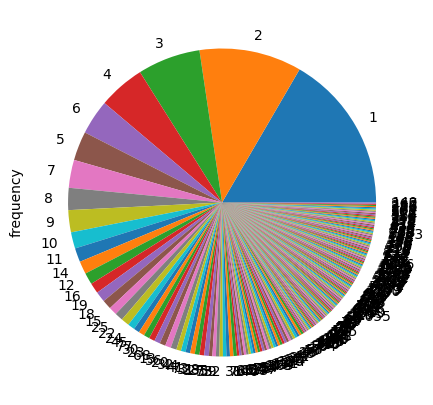

In [ ]:
frequencies.frequency.value_counts().plot(kind="pie", figsize=(5, 5))

✏️ Try it out! Compute the average rating per drug and store the result.

In [ ]:
train_df["average_rating"] = train_df.groupby("drugName")["rating"].transform("mean")

train_df.head()

patient_id                  drugName                     condition  \
0       95260                Guanfacine                          adhd   
1       92703                    Lybrel                 birth control   
2      138000                Ortho Evra                 birth control   
3       35696  Buprenorphine / naloxone             opiate dependence   
4      155963                    Cialis  benign prostatic hyperplasia   

                                              review  rating  \
0  "My son is halfway through his fourth week of ...     8.0   
1  "I used to take another oral contraceptive, wh...     5.0   
2  "This is my first time using any form of birth...     8.0   
3  "Suboxone has completely turned my life around...     9.0   
4  "2nd day on 5mg started to work with rock hard...     2.0   

                date  usefulCount  review_length  average_rating  
0     April 27, 2010          192            141        6.000000  
1  December 14, 2009           17            134        7.600000  
2   November 3, 2015           10             89        7.526066  
3  November 27, 2016           37            124        8.522427  
4  November 28, 2015           43             68        8.697872

And once we’re done with our Pandas analysis, we can always create a new Dataset object by using the `Dataset.from_pandas()` function as follows:

In [ ]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

Dataset({
    features: ['condition', 'frequency'],
    num_rows: 819
})

This wraps up our tour of the various preprocessing techniques available in 🤗 Datasets.

To round out the section, `let’s create a validation set to prepare the dataset for training a classifier on`.

Before doing so, we’ll `reset the output format of drug_dataset from "pandas" to "arrow"`

In [ ]:
drug_dataset.reset_format()

####**Creating a validation set split from training set**
Although we have a test set we could use for evaluation, it’s a good practice to leave the test set untouched and create a separate validation set during development. Once you are happy with the performance of your models on the validation set, you can do a final sanity check on the test set. This process helps mitigate the risk that you’ll overfit to the test set and deploy a model that fails on real-world data.

🤗 Datasets provides a `Dataset.train_test_split()` function that is based on the famous functionality from `scikit-learn`.

Let’s use it to `split our training set into train and validation splits` (we set the seed argument for reproducibility):

In [ ]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)

# Rename the default "test" split from the above splitting to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")

# Add the "test" set to our `DatasetDict` i.e drug_dataset_clean
drug_dataset_clean["test"] = drug_dataset["test"]

drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

Great, we’ve now prepared a dataset that’s ready for training some models on!

In section 5 we’ll show you how to upload datasets to the Hugging Face Hub, but for now let’s cap off our analysis by looking at a few ways you can save datasets on your local machine.

####**Saving a dataset to disk**

Although 🤗 Datasets will cache every downloaded dataset and the operations performed on it, there are times when you’ll want to save a dataset to disk (e.g., in case the cache gets deleted). As shown in the table below, 🤗 `Datasets provides three main functions to save your dataset in different formats`:
```
---------------------------------------
Data format  	Function
---------------------------------------
Arrow          Dataset.save_to_disk()
CSV	        Dataset.to_csv()
JSON	       Dataset.to_json()
```

For example, let’s save our cleaned dataset in the Arrow format:



In [ ]:
drug_dataset_clean.save_to_disk("drug-reviews")

Saving the dataset (0/1 shards):   0%|          | 0/110811 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/27703 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/46108 [00:00<?, ? examples/s]


This will create a directory with the following structure:

```
drug-reviews/
├── dataset_dict.json
├── test
│   ├── dataset.arrow
│   ├── dataset_info.json
│   └── state.json
├── train
│   ├── dataset.arrow
│   ├── dataset_info.json
│   ├── indices.arrow
│   └── state.json
└── validation
    ├── dataset.arrow
    ├── dataset_info.json
    ├── indices.arrow
    └── state.json
```

where we can see that each split is associated with its own `dataset.arrow table`, and some `metadata in dataset_info.json and state.json`.

You can think of the `Arrow format as a fancy table of columns and rows that is optimized for building high-performance applications that process and transport large datasets`.

Once the dataset is saved, we can `load` it by using the `load_from_disk()` function as follows:

In [ ]:
from datasets import load_from_disk

drug_dataset_reloaded = load_from_disk("drug-reviews")
drug_dataset_reloaded

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

For the `CSV and JSON formats`, we have to `store each split as a separate file`.

One way to do this is `by iterating over the keys and values in the DatasetDict object`

In [ ]:
for split, dataset in drug_dataset_clean.items():
    dataset.to_json(f"drug-reviews-{split}.json") #just json

In [ ]:
!head -n 1 drug-reviews-train.json #view the saved data

{"patient_id":89879,"drugName":"Cyclosporine","condition":"keratoconjunctivitis sicca","review":"\"I have used Restasis for about a year now and have seen almost no progress.  For most of my life I've had red and bothersome eyes. After trying various eye drops, my doctor recommended Restasis.  He said it typically takes 3 to 6 months for it to really kick in but it never did kick in.  When I put the drops in it burns my eyes for the first 30 - 40 minutes.  I've talked with my doctor about this and he said it is normal but should go away after some time, but it hasn't. Every year around spring time my eyes get terrible irritated  and this year has been the same (maybe even worse than other years) even though I've been using Restasis for a year now. The only difference I notice was for the first couple weeks, but now I'm ready to move on.\"","rating":2.0,"date":"April 20, 2013","usefulCount":69,"review_length":147}


In [ ]:
for split, dataset in drug_dataset_clean.items():
    dataset.to_json(f"drug-reviews-{split}.jsonl")#jsonl

Creating json from Arrow format:   0%|          | 0/111 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/28 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]

This `saves each split in JSON Lines format`, where `each row in the dataset is stored as a single line of JSON`.

Here’s what the first example looks like:

In [ ]:
!head -n 1 drug-reviews-train.jsonl

{"patient_id":89879,"drugName":"Cyclosporine","condition":"keratoconjunctivitis sicca","review":"\"I have used Restasis for about a year now and have seen almost no progress.  For most of my life I've had red and bothersome eyes. After trying various eye drops, my doctor recommended Restasis.  He said it typically takes 3 to 6 months for it to really kick in but it never did kick in.  When I put the drops in it burns my eyes for the first 30 - 40 minutes.  I've talked with my doctor about this and he said it is normal but should go away after some time, but it hasn't. Every year around spring time my eyes get terrible irritated  and this year has been the same (maybe even worse than other years) even though I've been using Restasis for a year now. The only difference I notice was for the first couple weeks, but now I'm ready to move on.\"","rating":2.0,"date":"April 20, 2013","usefulCount":69,"review_length":147}


We can then use the techniques from section 2 to load the JSON files as follows:

In [ ]:
from datasets import load_dataset
data_files = {
    "train": "drug-reviews-train.jsonl",
    "validation": "drug-reviews-validation.jsonl",
    "test": "drug-reviews-test.jsonl",
}
drug_dataset_reloaded = load_dataset("json", data_files=data_files)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

And that’s it for our excursion into data wrangling with 🤗 Datasets!

Now that we have a cleaned dataset for training a model on, here are a few ideas that you could try out:

1. Use the techniques from Chapter 3 to train a classifier that can predict the patient condition based on the drug review.
2. Use the summarization pipeline from Chapter 1 to generate summaries of the reviews.

Next, we’ll take a look at how 🤗 Datasets can enable you to work with huge datasets without blowing up your laptop!

####**Big data? 🤗 Datasets to the rescue!**

Nowadays it is not uncommon to find yourself `working with multi-gigabyte datasets`, especially if you’re planning to `pretrain a transformer like BERT or GPT-2 from scratch`.

In these cases, even `loading the data can be a challenge`.

For example, the `WebText corpus` used to pretrain GPT-2 consists of over **8 million documents and 40 GB of text** — loading this into your laptop’s RAM is likely to give it a heart attack!

Fortunately, 🤗 `Datasets has been designed to overcome these limitations`. It frees you from memory management problems by
- treating datasets as `memory-mapped files`, - and from hard drive limits by `streaming the entries` in a corpus.

In this section we’ll explore these features of 🤗 Datasets with a huge `825 GB corpus` known as the `Pile`. Let’s get started!

**What is the Pile?**

The Pile is an `English text corpus` that was created by EleutherAI for training large-scale language models. It includes a `diverse range of datasets, spanning scientific articles, GitHub code repositories, and filtered web text`. The training corpus is available in 14 GB chunks, and you can also download several of the individual components.

Let’s start by taking a look at the `PubMed Abstracts dataset`, which is a `corpus of abstracts from 15 million biomedical publications on PubMed`. The dataset is in JSON Lines format and is compressed using the `zstandard library`, so first we need to install that

In [ ]:
!pip install zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.2 MB/s eta 0:00:00


Next, we can load the dataset using the method for remote files that we learned in section 2:

In [ ]:
from datasets import load_dataset

# This takes a few minutes to run, so go grab a tea or coffee while you wait :)
# data_files = "https://mystic.the-eye.eu/public/AI/pile_preliminary_components/PUBMED_title_abstracts_2019_baseline.jsonl.zst" #link broken
# pumbed_dataset = load_dataset("json", data_files=data_files, split="train")

#another large datatset c4 directly from hub
# load c4 dataset from the en directory on the Hub-  https://huggingface.co/docs/datasets/loading#local-and-remote-files
c4_subset = load_dataset("allenai/c4", data_dir="en")
c4_subset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

We can see that there are 15,518,009 rows and 2 columns in our dataset — that’s a lot!

✎ By default, 🤗 `Datasets` will `decompress the files` needed to load a dataset. If you want `to preserve hard drive space`, you can pass `DownloadConfig(delete_extracted=True)` to the `download_config` argument of `load_dataset(`). See the documentation for more details. https://huggingface.co/docs/datasets/package_reference/builder_classes.html?#datasets.utils.DownloadConfig

Let’s inspect the contents of the first example:

In [ ]:
c4_dataset[0]

Okay, this looks like the abstract text. Now let’s see how much RAM we’ve used to load the dataset!

#####**The magic of memory mapping**
A simple way to measure memory usage in Python is with the `psutil library`, which can be installed with pip as follows:

In [ ]:
!pip install psutil

It provides a `Process class` that allows us `to check the memory usage of the current process` as follows:

In [ ]:
import psutil

# Process.memory_info is expressed in bytes, so convert to megabytes
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024) :.2f} MB")

Here the `rss attribute` refers to the `resident set size`, which is the `fraction of memory that a process occupies in RAM`. This measurement also includes the memory used by the Python interpreter and the libraries we’ve loaded, so the actual amount of memory used to load the dataset is a bit smaller.

For comparison, let’s see how large the dataset is on disk, using the `dataset_size attribute`. Since the result is expressed in `bytes` like before, we need to manually convert it to `gigabytes`:

In [ ]:
print(f"Number of files in dataset :{c4_dataset.dataset_size}")
size_gb = c4_dataset.dataset_size / (1024**3)
print(f"Dataset size (cache file) : {size_gb:.2f} GB")

Nice — despite it being almost 20 GB large, we’re able to load and access the dataset with much less RAM!

✏️ Try it out! Pick one of the subsets from the Pile that is larger than your laptop or desktop’s RAM, load it with 🤗 Datasets, and measure the amount of RAM used. Note that to get an accurate measurement, you’ll want to do this in a new process. You can find the decompressed sizes of each subset in Table 1 of the Pile paper.https://arxiv.org/abs/2101.00027

If you’re familiar with Pandas, this result might come as a surprise because of Wes Kinney’s famous **rule of thumb that you typically need 5 to 10 times as much RAM as the size of your dataset**.

**So how does 🤗 Datasets solve this memory management problem?**
 🤗 Datasets `treats each dataset as a memory-mapped file`, which `provides a mapping between RAM and filesystem storage` that allows the library to `access and operate on elements of the dataset without needing to fully load it into memory`.

**Memory-mapped files** can also be shared across multiple processes, which enables methods like `Dataset.map()` to be parallelized without needing to move or copy the dataset.

Under the hood, these capabilities are all realized by the `Apache Arrow memory format` and `pyarrow librar`y, which make the data loading and processing lightning fast. (For more details about Apache Arrow and comparisons to Pandas, check out Dejan Simic’s blog post. https://towardsdatascience.com/apache-arrow-read-dataframe-with-zero-memory-69634092b1a).

To see this in action, let’s run a little speed test by iterating over all the elements in the c4 dataset:

In [ ]:
import timeit

code_snippet = """batch_size = 1000

for idx in range(0, len(c4_dataset), batch_size):
    _ = c4_dataset[idx:idx + batch_size]
"""

time = timeit.timeit(stmt=code_snippet, number=1, globals=globals())
print(
    f"Iterated over {len(c4_dataset)} examples (about {size_gb:.1f} GB) in "
    f"{time:.1f}s, i.e. {size_gb/time:.3f} GB/s"
)

Here we’ve used Python’s `timeit module` to measure the execution time taken by code_snippet.

💡 In Jupyter notebooks you can also time cells using the `%%timeit magic function`.

You’ll typically be able to iterate over a dataset at speed of a few tenths of a GB/s to several GB/s. This works great for the vast majority of applications, `but sometimes you’ll have to work with a dataset that is too large to even store on your laptop’s hard drive`.

For example, if we tried to download the Pile in its entirety, we’d need 825 GB of free disk space! To handle these cases, 🤗 `Datasets provides a streaming feature` that `allows us to download and access elements on the fly, without needing to download the whole dataset`.

Let’s take a look at how this works.

#####**Streaming datasets**
To enable dataset streaming you just need to pass the `streaming=True` argument to the `load_dataset()` function.

For example, let’s load the c4 dataset again, but in `streaming mode`:

In [ ]:
c4_dataset_streamed = load_dataset(
    "c4", data_dir="en", split="train", streaming=True)

Instead of the familiar Dataset that we’ve encountered elsewhere in this chapter, the `object returned` with `streaming=True` is an `IterableDataset`.

As the name suggests, `to access the elements of an IterableDataset we need to iterate over it and we cant access using indexing`

 We can access the first element of our streamed dataset as follows:

In [ ]:
next(iter(c4_dataset_streamed))

The elements from a streamed dataset can be processed on the fly using `IterableDataset.map()`, which is useful `during training` if you need `to tokenize the inputs`.

The process is exactly the same as the one we used to tokenize our dataset in Chapter 3, with `the only difference being that outputs are returned one by one`

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_dataset = c4_dataset.map(lambda x: tokenizer(x["text"]))
next(iter(tokenized_dataset))

💡 To speed up tokenization with streaming you can pass `batched=True`, as we saw in the last section. It will `process the examples batch by batch`; the `default batch size is 1,000` and can be specified with the `batch_size` argument.

You can also `shuffle a streamed dataset` using `IterableDataset.shuffle()`, but unlike Dataset.shuffle() this `only shuffles the elements in a predefined buffer_size`

In [ ]:
shuffle_dataset = c4_dataset_streamed.shuffle(buffer_size=10_000, seed=42)
next(iter(shuffle_dataset))

In this example, we selected a random example from the first 10,000 examples in the buffer. Once an example is accessed, its spot in the buffer is filled with the next example in the corpus (i.e., the 10,001st example in the case above).

You can also `select elements from a streamed dataset` using the `IterableDataset.take()` and `IterableDataset.skip()` functions, which act in a similar way to `Dataset.select()`. '

For example, to select the first 5 examples in the c4 dataset we can do the following:

In [ ]:
dataset_head = c4_dataset_streamed.take(5)
list(dataset_head)

Similarly, you can use the `IterableDataset.skip()` function to `create training and validation splits from a shuffled dataset` as follows:

In [ ]:
# Skip the first 1,000 examples and include the rest in the training set
train_dataset = shuffled_dataset.skip(1000)
# Take the first 1,000 examples for the validation set
validation_dataset = shuffled_dataset.take(1000)

Let’s round out our exploration of dataset streaming with a common application:

- combining multiple datasets together to create a single corpus.

🤗 Datasets provides an `interleave_datasets()` function that `converts a list of IterableDataset objects into a single IterableDataset`, where the elements of the new dataset are obtained by alternating among the source examples.

This function is especially useful when you’re trying to combine large datasets, so as an example let’s stream the FreeLaw subset of the Pile, which is a 51 GB dataset of legal opinions from US courts:

In [ ]:
# law_dataset_streamed = load_dataset(
#     "json",
#     data_files="https://the-eye.eu/public/AI/pile_preliminary_components/FreeLaw_Opinions.jsonl.zst",
#     split="train",
#     streaming=True,
# )
# next(iter(law_dataset_streamed))

This dataset is large enough to stress the RAM of most laptops, yet we’ve been able to load and access it without breaking a sweat!

Let’s now combine the examples from the `FreeLaw and PubMed Abstracts datasets` with the `interleave_datasets()` function:

In [ ]:
# from itertools import islice
# from datasets import interleave_datasets

# combined_dataset = interleave_datasets([pubmed_dataset_streamed, law_dataset_streamed])
# list(islice(combined_dataset, 2))

Here we’ve used the `islice()` function from Python’s `itertools module` to select the first two examples from the combined dataset, and we can see that they match the first examples from each of the two source datasets.

Finally, if you want to stream the Pile in its 825 GB entirety, you can grab all the prepared files as follows:

In [ ]:
# base_url = "https://the-eye.eu/public/AI/pile/"
# data_files = {
#     "train": [base_url + "train/" + f"{idx:02d}.jsonl.zst" for idx in range(30)],
#     "validation": base_url + "val.jsonl.zst",
#     "test": base_url + "test.jsonl.zst",
# }
# pile_dataset = load_dataset("json", data_files=data_files, streaming=True)
# next(iter(pile_dataset["train"]))

✏️ Try it out! Use one of the large Common Crawl corpora like `mc4` or `oscar` to create a streaming multilingual dataset that represents the spoken proportions of languages in a country of your choice. For example, the four national languages in Switzerland are German, French, Italian, and Romansh, so you could try creating a Swiss corpus by sampling the Oscar subsets according to their spoken proportion.

You now have all the tools you need to load and process datasets of all shapes and sizes — but unless you’re exceptionally lucky, there will come a point in your NLP journey where you’ll have to actually create a dataset to solve the problem at hand. That’s the topic of the next section!

####**Creating own dataset and saving to hub**
https://huggingface.co/learn/nlp-course/chapter5/5?fw=pt - github request rest api endpoints, authorization headers